In [0]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [1]:
!ls

datalab  drive	logs


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [4]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [6]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [8]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [9]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [11]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [13]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)
X_train_flip = list()

In [15]:
train.shape

(28709, 1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)

  X_train_flip.append(data_augmentation(t3))
  return t3

In [0]:
def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)
  return t3

In [0]:
X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_test = np.apply_along_axis(reform_data, 1, test)
X_validation = np.apply_along_axis(reform_data, 1, validation)

In [20]:
np.array(X_train_flip).shape

(28709, 48, 48, 1)

In [21]:
X_train = np.array(list(X_train_1) + X_train_flip)
print(X_train.shape)

(57418, 48, 48, 1)


In [22]:
print(X_train.shape, X_test.shape, X_validation.shape)

(57418, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


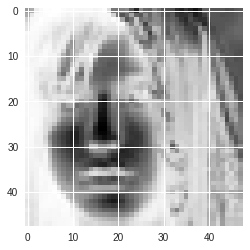

In [23]:
# Sample image
plt.imshow(X_train[0].reshape(48,48))

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_validation = X_validation/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [26]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [28]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [30]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [32]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [34]:
print(X_validation.shape, Y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation

## CNN Models
Taking 3 - 4 models for ensemble voting

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2

Using TensorFlow backend.


### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 1)

In [0]:
def Model1(input_shape=(48,48,1)):
  model = Sequential()
  
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [108]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       512       
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model1.load_weights("drive/face_expr_model1.h5")

In [47]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, tensorboard, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/300
43840/57418 [=====================>........] - ETA: 27s - loss: 0.3085 - acc: 0.8987

57418/57418 [==============================] - 120s 2ms/step - loss: 0.3182 - acc: 0.8963 - val_loss: 1.2731 - val_acc: 0.6709

Epoch 00001: val_loss improved from inf to 1.27313, saving model to /drive
Epoch 2/300
17408/57418 [========>.....................] - ETA: 1:19 - loss: 0.3355 - acc: 0.8915

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3466 - acc: 0.8868 - val_loss: 1.2974 - val_acc: 0.6489

Epoch 00002: val_loss did not improve from 1.27313
Epoch 3/300
10944/57418 [====>.........................] - ETA: 1:32 - loss: 0.3368 - acc: 0.8865

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3456 - acc: 0.8844 - val_loss: 1.3302 - val_acc: 0.6559

Epoch 00003: val_loss did not improve from 1.27313
Epoch 4/300
 8896/57418 [===>..........................] - ETA: 1:36 - loss: 0.3441 - acc: 0.8853

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3552 - acc: 0.8833 - val_loss: 1.2190 - val_acc: 0.6620

Epoch 00004: val_loss improved from 1.27313 to 1.21900, saving model to /drive
Epoch 5/300
 7488/57418 [==>...........................] - ETA: 1:40 - loss: 0.3480 - acc: 0.8868

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3649 - acc: 0.8793 - val_loss: 1.3062 - val_acc: 0.6601

Epoch 00005: val_loss did not improve from 1.21900
Epoch 6/300
 7872/57418 [===>..........................] - ETA: 1:39 - loss: 0.4933 - acc: 0.8368

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3878 - acc: 0.8713 - val_loss: 1.2542 - val_acc: 0.6704

Epoch 00006: val_loss did not improve from 1.21900
Epoch 7/300
 8000/57418 [===>..........................] - ETA: 1:38 - loss: 0.3756 - acc: 0.8776

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3630 - acc: 0.8800 - val_loss: 1.3386 - val_acc: 0.6592

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00007: val_loss did not improve from 1.21900
Epoch 8/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.4050 - acc: 0.8674

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3581 - acc: 0.8812 - val_loss: 1.2405 - val_acc: 0.6634

Epoch 00008: val_loss did not improve from 1.21900
Epoch 9/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3625 - acc: 0.8836

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3454 - acc: 0.8872 - val_loss: 1.2977 - val_acc: 0.6565

Epoch 00009: val_loss did not improve from 1.21900
Epoch 10/300
 7808/57418 [===>..........................] - ETA: 1:39 - loss: 0.3410 - acc: 0.8922

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3412 - acc: 0.8890 - val_loss: 1.3018 - val_acc: 0.6581

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00010: val_loss did not improve from 1.21900
Epoch 11/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.3206 - acc: 0.8910

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3303 - acc: 0.8903 - val_loss: 1.2574 - val_acc: 0.6665

Epoch 00011: val_loss did not improve from 1.21900
Epoch 12/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3074 - acc: 0.8994

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3177 - acc: 0.8942 - val_loss: 1.3263 - val_acc: 0.6701

Epoch 00012: val_loss did not improve from 1.21900
Epoch 00012: early stopping


In [0]:
model1.save_weights("drive/face_expr_model1.h5")

In [114]:
model1.evaluate(X_test, Y_test, batch_size=batch_size)


3589/3589 [==============================] - 2s 696us/step


[1.371711015502003, 0.6706603511059374]

In [0]:
model1_2 = Model1()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(horizontal_flip=True,
                        vertical_flip=True)
train_generator_1 = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model1_2.compile(loss=categorical_crossentropy
, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
, metrics=['accuracy']
)
 

In [118]:
model1_2.fit_generator(train_generator_1, steps_per_epoch=50, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2376 - acc: 0.5341
Epoch 2/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2549 - acc: 0.5416
Epoch 3/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2404 - acc: 0.5272
Epoch 4/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2757 - acc: 0.5347
Epoch 5/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2493 - acc: 0.5413
Epoch 6/1000
47/50 [===========================>..] - ETA: 0s - loss: 1.2344 - acc: 0.5422

50/50 [==============================] - 7s 131ms/step - loss: 1.2348 - acc: 0.5406
Epoch 7/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2134 - acc: 0.5606
Epoch 8/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2201 - acc: 0.5525
Epoch 9/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2243 - acc: 0.5375
Epoch 10/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2359 - acc: 0.5316
Epoch 11/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2312 - acc: 0.5269
Epoch 12/1000
 8/50 [===>..........................] - ETA: 5s - loss: 1.2377 - acc: 0.5449

50/50 [==============================] - 7s 131ms/step - loss: 1.2624 - acc: 0.5341
Epoch 13/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2233 - acc: 0.5513
Epoch 14/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.2308 - acc: 0.5469
Epoch 15/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.2288 - acc: 0.5550
Epoch 16/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2343 - acc: 0.5387
Epoch 17/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2243 - acc: 0.5509
Epoch 18/1000
 2/50 [>.............................] - ETA: 6s - loss: 0.9671 - acc: 0.5859

50/50 [==============================] - 7s 131ms/step - loss: 1.2114 - acc: 0.5384
Epoch 19/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2072 - acc: 0.5456
Epoch 20/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2240 - acc: 0.5581
Epoch 21/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.2009 - acc: 0.5510
Epoch 22/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.2218 - acc: 0.5384
Epoch 23/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2292 - acc: 0.5409
Epoch 24/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.0957 - acc: 0.5781

50/50 [==============================] - 7s 131ms/step - loss: 1.2089 - acc: 0.5534
Epoch 25/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2321 - acc: 0.5341
Epoch 26/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1920 - acc: 0.5516
Epoch 27/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2396 - acc: 0.5513
Epoch 28/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1975 - acc: 0.5578
Epoch 29/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.2139 - acc: 0.5422
Epoch 30/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.0957 - acc: 0.6094

50/50 [==============================] - 6s 130ms/step - loss: 1.2032 - acc: 0.5572
Epoch 31/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1799 - acc: 0.5719
Epoch 32/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2290 - acc: 0.5425
Epoch 33/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2235 - acc: 0.5400
Epoch 34/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1729 - acc: 0.5675
Epoch 35/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1865 - acc: 0.5650
Epoch 36/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1787 - acc: 0.5469

50/50 [==============================] - 6s 130ms/step - loss: 1.2226 - acc: 0.5338
Epoch 37/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2265 - acc: 0.5491
Epoch 38/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1931 - acc: 0.5581
Epoch 39/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1952 - acc: 0.5572
Epoch 40/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2057 - acc: 0.5503
Epoch 41/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1658 - acc: 0.5809
Epoch 42/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2460 - acc: 0.5469

50/50 [==============================] - 7s 130ms/step - loss: 1.1911 - acc: 0.5650
Epoch 43/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.2075 - acc: 0.5409
Epoch 44/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1982 - acc: 0.5559
Epoch 45/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1738 - acc: 0.5486
Epoch 46/1000
50/50 [==============================] - 7s 132ms/step - loss: 1.2244 - acc: 0.5544
Epoch 47/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.2187 - acc: 0.5487
Epoch 48/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2576 - acc: 0.4922

50/50 [==============================] - 7s 131ms/step - loss: 1.1968 - acc: 0.5453
Epoch 49/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1911 - acc: 0.5566
Epoch 50/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1776 - acc: 0.5591
Epoch 51/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2026 - acc: 0.5672
Epoch 52/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1820 - acc: 0.5675
Epoch 53/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2226 - acc: 0.5472
Epoch 54/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1662 - acc: 0.5859

50/50 [==============================] - 6s 130ms/step - loss: 1.1727 - acc: 0.5731
Epoch 55/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1895 - acc: 0.5591
Epoch 56/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1673 - acc: 0.5700
Epoch 57/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1704 - acc: 0.5747
Epoch 58/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.2110 - acc: 0.5513
Epoch 59/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1755 - acc: 0.5653
Epoch 60/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.3884 - acc: 0.5391

50/50 [==============================] - 7s 131ms/step - loss: 1.1723 - acc: 0.5634
Epoch 61/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1893 - acc: 0.5625
Epoch 62/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.2149 - acc: 0.5509
Epoch 63/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1747 - acc: 0.5694
Epoch 64/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1882 - acc: 0.5709
Epoch 65/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1891 - acc: 0.5650
Epoch 66/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2610 - acc: 0.5234

50/50 [==============================] - 7s 130ms/step - loss: 1.2032 - acc: 0.5466
Epoch 67/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1845 - acc: 0.5625
Epoch 68/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1738 - acc: 0.5563
Epoch 69/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1729 - acc: 0.5669
Epoch 70/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1768 - acc: 0.5731
Epoch 71/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1866 - acc: 0.5606
Epoch 72/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1873 - acc: 0.5703

50/50 [==============================] - 7s 130ms/step - loss: 1.1986 - acc: 0.5644
Epoch 73/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1757 - acc: 0.5672
Epoch 74/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1652 - acc: 0.5663
Epoch 75/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1727 - acc: 0.5634
Epoch 76/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1338 - acc: 0.5772
Epoch 77/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1519 - acc: 0.5734
Epoch 78/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2970 - acc: 0.4688

50/50 [==============================] - 7s 130ms/step - loss: 1.2008 - acc: 0.5597
Epoch 79/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1501 - acc: 0.5813
Epoch 80/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1628 - acc: 0.5731
Epoch 81/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1641 - acc: 0.5787
Epoch 82/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1739 - acc: 0.5728
Epoch 83/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1789 - acc: 0.5684
Epoch 84/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1706 - acc: 0.5703

50/50 [==============================] - 7s 131ms/step - loss: 1.1942 - acc: 0.5616
Epoch 85/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1737 - acc: 0.5731
Epoch 86/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1631 - acc: 0.5700
Epoch 87/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1588 - acc: 0.5709
Epoch 88/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1515 - acc: 0.5737
Epoch 89/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1553 - acc: 0.5731
Epoch 90/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.2252 - acc: 0.5859

50/50 [==============================] - 7s 131ms/step - loss: 1.1920 - acc: 0.5716
Epoch 91/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1516 - acc: 0.5750
Epoch 92/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1389 - acc: 0.5944
Epoch 93/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1732 - acc: 0.5741
Epoch 94/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1427 - acc: 0.5787
Epoch 95/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1874 - acc: 0.5713
Epoch 96/1000
 2/50 [>.............................] - ETA: 6s - loss: 1.1192 - acc: 0.5391

50/50 [==============================] - 7s 131ms/step - loss: 1.1542 - acc: 0.5819
Epoch 97/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1654 - acc: 0.5694
Epoch 98/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1486 - acc: 0.5906
Epoch 99/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1383 - acc: 0.5766
Epoch 100/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1609 - acc: 0.5741
Epoch 101/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1863 - acc: 0.5761
Epoch 102/1000
 1/50 [..............................] - ETA: 6s - loss: 1.1360 - acc: 0.5938

50/50 [==============================] - 7s 130ms/step - loss: 1.1544 - acc: 0.5644
Epoch 103/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1443 - acc: 0.5809
Epoch 104/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1863 - acc: 0.5637
Epoch 105/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1456 - acc: 0.5803
Epoch 106/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1511 - acc: 0.5825
Epoch 107/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1632 - acc: 0.5697
Epoch 108/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1622 - acc: 0.5697
Epoch 109/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1750 - acc: 0.5678
Epoch 110/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1687 - acc: 0.5813
Epoch 111/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0920 - acc: 0.6050
Epoch 112/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1618 - acc: 0.5791
Epoch 113/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1530 - acc: 0.5800
Epoch 114/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1626 - acc: 0.5747
Epoch 115/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1297 - acc: 0.5887
Epoch 116/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1569 - acc: 0.5697
Epoch 117/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1497 - acc: 0.5844
Epoch 118/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1504 - acc: 0.5700
Epoch 119/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1661 - acc: 0.5687
Epoch 120/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.1241 - acc: 0.5953
Epoch 121/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1455 - acc: 0.5766
Epoch 122/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1145 - acc: 0.5938
Epoch 123/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1615 - acc: 0.5637
Epoch 124/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1453 - acc: 0.5881
Epoch 125/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1475 - acc: 0.5808
Epoch 126/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0998 - acc: 0.6006
Epoch 127/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1182 - acc: 0.5944
Epoch 128/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1118 - acc: 0.5863
Epoch 129/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1295 - acc: 0.5894
Epoch 130/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0878 - acc: 0.6112
Epoch 131/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1255 - acc: 0.5903
Epoch 132/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1205 - acc: 0.5866
Epoch 133/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1178 - acc: 0.6031
Epoch 134/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1325 - acc: 0.5901
Epoch 135/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1421 - acc: 0.5881
Epoch 136/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1627 - acc: 0.5806
Epoch 137/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1412 - acc: 0.5866
Epoch 138/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.1103 - acc: 0.5928
Epoch 139/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1735 - acc: 0.5687
Epoch 140/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1528 - acc: 0.5734
Epoch 141/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1582 - acc: 0.5759
Epoch 142/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1430 - acc: 0.5859
Epoch 143/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1211 - acc: 0.5984
Epoch 144/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1146 - acc: 0.5869
Epoch 145/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1053 - acc: 0.6003
Epoch 146/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0901 - acc: 0.6019
Epoch 147/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1054 - acc: 0.5922
Epoch 148/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1121 - acc: 0.5822
Epoch 149/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1305 - acc: 0.5919
Epoch 150/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.1264 - acc: 0.5800
Epoch 151/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1302 - acc: 0.5880
Epoch 152/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1399 - acc: 0.5847
Epoch 153/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0933 - acc: 0.6019
Epoch 154/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1147 - acc: 0.5819
Epoch 155/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1414 - acc: 0.5878
Epoch 156/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.1135 - acc: 0.5859
Epoch 157/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1070 - acc: 0.5837
Epoch 158/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1443 - acc: 0.5850
Epoch 159/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1141 - acc: 0.5853
Epoch 160/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0550 - acc: 0.6238
Epoch 161/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1231 - acc: 0.5869
Epoch 162/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1177 - acc: 0.5928
Epoch 163/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1262 - acc: 0.5912
Epoch 164/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1050 - acc: 0.5994
Epoch 165/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1028 - acc: 0.5941
Epoch 166/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1090 - acc: 0.5906
Epoch 167/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0893 - acc: 0.6072
Epoch 168/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.1088 - acc: 0.6028
Epoch 169/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1153 - acc: 0.5916
Epoch 170/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0883 - acc: 0.6076
Epoch 171/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0979 - acc: 0.5931
Epoch 172/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1106 - acc: 0.5897
Epoch 173/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1112 - acc: 0.5963
Epoch 174/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.1267 - acc: 0.5900
Epoch 175/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1411 - acc: 0.5822
Epoch 176/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0900 - acc: 0.6034
Epoch 177/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0990 - acc: 0.5947
Epoch 178/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1075 - acc: 0.5928
Epoch 179/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1019 - acc: 0.5959
Epoch 180/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0873 - acc: 0.5991
Epoch 181/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1109 - acc: 0.5963
Epoch 182/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1042 - acc: 0.5922
Epoch 183/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0972 - acc: 0.6059
Epoch 184/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0893 - acc: 0.5934
Epoch 185/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1020 - acc: 0.5981
Epoch 186/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0921 - acc: 0.6050
Epoch 187/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0873 - acc: 0.5984
Epoch 188/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1049 - acc: 0.5991
Epoch 189/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0787 - acc: 0.6094
Epoch 190/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1101 - acc: 0.5990
Epoch 191/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0871 - acc: 0.6038
Epoch 192/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0907 - acc: 0.6025
Epoch 193/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0508 - acc: 0.6153
Epoch 194/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.1151 - acc: 0.6050
Epoch 195/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0786 - acc: 0.6028
Epoch 196/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0919 - acc: 0.6072
Epoch 197/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.1349 - acc: 0.5875
Epoch 198/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.1044 - acc: 0.5900
Epoch 199/1000
50/50 [==============================] - 6s 128ms/step - loss: 1.0837 - acc: 0.6068
Epoch 200/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0784 - acc: 0.6019
Epoch 201/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0733 - acc: 0.6069
Epoch 202/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0842 - acc: 0.6053
Epoch 203/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0877 - acc: 0.5994
Epoch 204/1000


50/50 [==============================] - 6s 129ms/step - loss: 1.0746 - acc: 0.6062
Epoch 205/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.1095 - acc: 0.6025
Epoch 206/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0776 - acc: 0.6038
Epoch 207/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0807 - acc: 0.6059
Epoch 208/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0868 - acc: 0.6088
Epoch 209/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0928 - acc: 0.5856
Epoch 210/1000


50/50 [==============================] - 6s 129ms/step - loss: 1.0496 - acc: 0.6144
Epoch 211/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1013 - acc: 0.5975
Epoch 212/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0934 - acc: 0.5991
Epoch 213/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0939 - acc: 0.5975
Epoch 214/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0745 - acc: 0.6059
Epoch 215/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0643 - acc: 0.6131
Epoch 216/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0725 - acc: 0.6053
Epoch 217/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0913 - acc: 0.5972
Epoch 218/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0835 - acc: 0.6019
Epoch 219/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0696 - acc: 0.6106
Epoch 220/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0800 - acc: 0.6050
Epoch 221/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0832 - acc: 0.6053
Epoch 222/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0783 - acc: 0.6097
Epoch 223/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0752 - acc: 0.6238
Epoch 224/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.1081 - acc: 0.5994
Epoch 225/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0552 - acc: 0.6156
Epoch 226/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0914 - acc: 0.5973
Epoch 227/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0920 - acc: 0.5947
Epoch 228/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0652 - acc: 0.6097
Epoch 229/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0750 - acc: 0.6131
Epoch 230/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0880 - acc: 0.6047
Epoch 231/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0491 - acc: 0.6147
Epoch 232/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0846 - acc: 0.6009
Epoch 233/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0549 - acc: 0.6056
Epoch 234/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0332 - acc: 0.6188
Epoch 235/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0607 - acc: 0.6147
Epoch 236/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0527 - acc: 0.6138
Epoch 237/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0469 - acc: 0.6197
Epoch 238/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0572 - acc: 0.6150
Epoch 239/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0644 - acc: 0.6122
Epoch 240/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0749 - acc: 0.6022
Epoch 241/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0574 - acc: 0.6112
Epoch 242/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0554 - acc: 0.6162
Epoch 243/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0584 - acc: 0.6191
Epoch 244/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0749 - acc: 0.6141
Epoch 245/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0687 - acc: 0.6016
Epoch 246/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0828 - acc: 0.6056
Epoch 247/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0649 - acc: 0.6016
Epoch 248/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0610 - acc: 0.6088
Epoch 249/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0764 - acc: 0.5994
Epoch 250/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0966 - acc: 0.6044
Epoch 251/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0968 - acc: 0.5869
Epoch 252/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0129 - acc: 0.6294
Epoch 253/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0110 - acc: 0.6269
Epoch 254/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0530 - acc: 0.6272
Epoch 255/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0544 - acc: 0.6121
Epoch 256/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0348 - acc: 0.6316
Epoch 257/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0405 - acc: 0.6269
Epoch 258/1000


50/50 [==============================] - 6s 129ms/step - loss: 1.0772 - acc: 0.6134
Epoch 259/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0641 - acc: 0.6103
Epoch 260/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0477 - acc: 0.6184
Epoch 261/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0920 - acc: 0.6050
Epoch 262/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0461 - acc: 0.6147
Epoch 263/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0438 - acc: 0.6300
Epoch 264/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0324 - acc: 0.6225
Epoch 265/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0765 - acc: 0.6038
Epoch 266/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0625 - acc: 0.6172
Epoch 267/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0381 - acc: 0.6225
Epoch 268/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0498 - acc: 0.6216
Epoch 269/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0751 - acc: 0.6106
Epoch 270/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0895 - acc: 0.5928
Epoch 271/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0297 - acc: 0.6194
Epoch 272/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0198 - acc: 0.6309
Epoch 273/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0459 - acc: 0.6200
Epoch 274/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0447 - acc: 0.6166
Epoch 275/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0189 - acc: 0.6197
Epoch 276/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9814 - acc: 0.6407
Epoch 277/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0696 - acc: 0.6084
Epoch 278/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0691 - acc: 0.6022
Epoch 279/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0589 - acc: 0.6181
Epoch 280/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0265 - acc: 0.6188
Epoch 281/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0638 - acc: 0.6181
Epoch 282/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0570 - acc: 0.6222
Epoch 283/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0446 - acc: 0.6172
Epoch 284/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0761 - acc: 0.6066
Epoch 285/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0618 - acc: 0.6266
Epoch 286/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0702 - acc: 0.6125
Epoch 287/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0455 - acc: 0.6159
Epoch 288/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0554 - acc: 0.6172
Epoch 289/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0372 - acc: 0.6131
Epoch 290/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0428 - acc: 0.6122
Epoch 291/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0431 - acc: 0.6231
Epoch 292/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0452 - acc: 0.6206
Epoch 293/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0499 - acc: 0.6138
Epoch 294/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0117 - acc: 0.6412
Epoch 295/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0248 - acc: 0.6209
Epoch 296/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0363 - acc: 0.6294
Epoch 297/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0620 - acc: 0.6203
Epoch 298/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0135 - acc: 0.6394
Epoch 299/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0445 - acc: 0.6312
Epoch 300/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0589 - acc: 0.6122
Epoch 301/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0144 - acc: 0.6216
Epoch 302/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0320 - acc: 0.6282
Epoch 303/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0599 - acc: 0.6219
Epoch 304/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0548 - acc: 0.6228
Epoch 305/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0446 - acc: 0.6247
Epoch 306/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9987 - acc: 0.6375
Epoch 307/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0076 - acc: 0.6316
Epoch 308/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0277 - acc: 0.6372
Epoch 309/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0519 - acc: 0.6131
Epoch 310/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0377 - acc: 0.6128
Epoch 311/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0047 - acc: 0.6297
Epoch 312/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0336 - acc: 0.6328
Epoch 313/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0127 - acc: 0.6166
Epoch 314/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0063 - acc: 0.6309
Epoch 315/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0106 - acc: 0.6406
Epoch 316/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0218 - acc: 0.6309
Epoch 317/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0386 - acc: 0.6254
Epoch 318/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0314 - acc: 0.6287
Epoch 319/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0299 - acc: 0.6256
Epoch 320/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0285 - acc: 0.6181
Epoch 321/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0521 - acc: 0.6266
Epoch 322/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0435 - acc: 0.6153
Epoch 323/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9906 - acc: 0.6431
Epoch 324/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0476 - acc: 0.6141
Epoch 325/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0215 - acc: 0.6317
Epoch 326/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0197 - acc: 0.6238
Epoch 327/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9940 - acc: 0.6416
Epoch 328/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9851 - acc: 0.6375
Epoch 329/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0118 - acc: 0.6312
Epoch 330/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0355 - acc: 0.6253
Epoch 331/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0086 - acc: 0.6400
Epoch 332/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0037 - acc: 0.6353
Epoch 333/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0117 - acc: 0.6325
Epoch 334/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0312 - acc: 0.6241
Epoch 335/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0170 - acc: 0.6341
Epoch 336/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0167 - acc: 0.6328
Epoch 337/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0309 - acc: 0.6228
Epoch 338/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0303 - acc: 0.6316
Epoch 339/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0233 - acc: 0.6325
Epoch 340/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9975 - acc: 0.6284
Epoch 341/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0334 - acc: 0.6153
Epoch 342/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0357 - acc: 0.6209
Epoch 343/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9865 - acc: 0.6506
Epoch 344/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9931 - acc: 0.6338
Epoch 345/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9887 - acc: 0.6472
Epoch 346/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0272 - acc: 0.6203
Epoch 347/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9663 - acc: 0.6462
Epoch 348/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0244 - acc: 0.6334
Epoch 349/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0192 - acc: 0.6347
Epoch 350/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9988 - acc: 0.6271
Epoch 351/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0557 - acc: 0.6278
Epoch 352/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0089 - acc: 0.6309
Epoch 353/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0133 - acc: 0.6284
Epoch 354/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9920 - acc: 0.6459
Epoch 355/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0040 - acc: 0.6350
Epoch 356/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0045 - acc: 0.6381
Epoch 357/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0248 - acc: 0.6147
Epoch 358/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0233 - acc: 0.6284
Epoch 359/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0044 - acc: 0.6362
Epoch 360/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0182 - acc: 0.6356
Epoch 361/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9858 - acc: 0.6450
Epoch 362/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0103 - acc: 0.6234
Epoch 363/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0154 - acc: 0.6256
Epoch 364/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9977 - acc: 0.6462
Epoch 365/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0076 - acc: 0.6397
Epoch 366/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0145 - acc: 0.6441
Epoch 367/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0159 - acc: 0.6312
Epoch 368/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9935 - acc: 0.6491
Epoch 369/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9969 - acc: 0.6394
Epoch 370/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0181 - acc: 0.6303
Epoch 371/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9844 - acc: 0.6369
Epoch 372/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9838 - acc: 0.6388
Epoch 373/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0082 - acc: 0.6281
Epoch 374/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0301 - acc: 0.6253
Epoch 375/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9887 - acc: 0.6333
Epoch 376/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0101 - acc: 0.6353
Epoch 377/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0311 - acc: 0.6259
Epoch 378/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9956 - acc: 0.6578
Epoch 379/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9925 - acc: 0.6403
Epoch 380/1000
50/50 [==============================] - 6s 129ms/step - loss: 1.0031 - acc: 0.6356
Epoch 381/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9791 - acc: 0.6491
Epoch 382/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9797 - acc: 0.6375
Epoch 383/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9666 - acc: 0.6425
Epoch 384/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0089 - acc: 0.6278
Epoch 385/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0139 - acc: 0.6334
Epoch 386/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9690 - acc: 0.6416
Epoch 387/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9843 - acc: 0.6444
Epoch 388/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9937 - acc: 0.6425
Epoch 389/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0301 - acc: 0.6241
Epoch 390/1000


50/50 [==============================] - 6s 130ms/step - loss: 1.0215 - acc: 0.6297
Epoch 391/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0009 - acc: 0.6344
Epoch 392/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9613 - acc: 0.6491
Epoch 393/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0069 - acc: 0.6238
Epoch 394/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0065 - acc: 0.6244
Epoch 395/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0066 - acc: 0.6153
Epoch 396/1000


50/50 [==============================] - 7s 130ms/step - loss: 1.0021 - acc: 0.6372
Epoch 397/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9464 - acc: 0.6522
Epoch 398/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9742 - acc: 0.6519
Epoch 399/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9616 - acc: 0.6453
Epoch 400/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9969 - acc: 0.6403
Epoch 401/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9473 - acc: 0.6478
Epoch 402/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9616 - acc: 0.6509
Epoch 403/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0105 - acc: 0.6338
Epoch 404/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9934 - acc: 0.6391
Epoch 405/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9844 - acc: 0.6394
Epoch 406/1000
50/50 [==============================] - 7s 131ms/step - loss: 1.0264 - acc: 0.6300
Epoch 407/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9651 - acc: 0.6447
Epoch 408/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9852 - acc: 0.6388
Epoch 409/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9753 - acc: 0.6410
Epoch 410/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9896 - acc: 0.6409
Epoch 411/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9805 - acc: 0.6456
Epoch 412/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9788 - acc: 0.6488
Epoch 413/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9821 - acc: 0.6412
Epoch 414/1000


50/50 [==============================] - 7s 131ms/step - loss: 1.0121 - acc: 0.6334
Epoch 415/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9626 - acc: 0.6509
Epoch 416/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9750 - acc: 0.6472
Epoch 417/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9734 - acc: 0.6419
Epoch 418/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0215 - acc: 0.6334
Epoch 419/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9911 - acc: 0.6453
Epoch 420/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9822 - acc: 0.6559
Epoch 421/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9810 - acc: 0.6384
Epoch 422/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9568 - acc: 0.6556
Epoch 423/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9728 - acc: 0.6544
Epoch 424/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9543 - acc: 0.6472
Epoch 425/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9691 - acc: 0.6406
Epoch 426/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9948 - acc: 0.6241
Epoch 427/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9947 - acc: 0.6422
Epoch 428/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9551 - acc: 0.6484
Epoch 429/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9922 - acc: 0.6391
Epoch 430/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9983 - acc: 0.6453
Epoch 431/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9687 - acc: 0.6488
Epoch 432/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9774 - acc: 0.6516
Epoch 433/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9682 - acc: 0.6512
Epoch 434/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9749 - acc: 0.6459
Epoch 435/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9917 - acc: 0.6400
Epoch 436/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9456 - acc: 0.6519
Epoch 437/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0013 - acc: 0.6219
Epoch 438/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9851 - acc: 0.6350
Epoch 439/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9675 - acc: 0.6506
Epoch 440/1000
50/50 [==============================] - 6s 130ms/step - loss: 1.0053 - acc: 0.6384
Epoch 441/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9465 - acc: 0.6597
Epoch 442/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9834 - acc: 0.6447
Epoch 443/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9384 - acc: 0.6566
Epoch 444/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9608 - acc: 0.6484
Epoch 445/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9838 - acc: 0.6316
Epoch 446/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9841 - acc: 0.6381
Epoch 447/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9646 - acc: 0.6503
Epoch 448/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9798 - acc: 0.6350
Epoch 449/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9658 - acc: 0.6635
Epoch 450/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9934 - acc: 0.6434
Epoch 451/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9814 - acc: 0.6394
Epoch 452/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9540 - acc: 0.6538
Epoch 453/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9678 - acc: 0.6566
Epoch 454/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9621 - acc: 0.6534
Epoch 455/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9408 - acc: 0.6566
Epoch 456/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9859 - acc: 0.6391
Epoch 457/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9650 - acc: 0.6419
Epoch 458/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9909 - acc: 0.6406
Epoch 459/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9589 - acc: 0.6431
Epoch 460/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9541 - acc: 0.6494
Epoch 461/1000
50/50 [==============================] - 7s 130ms/step - loss: 1.0018 - acc: 0.6419
Epoch 462/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9696 - acc: 0.6627
Epoch 463/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9912 - acc: 0.6397
Epoch 464/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9270 - acc: 0.6569
Epoch 465/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9870 - acc: 0.6347
Epoch 466/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9598 - acc: 0.6531
Epoch 467/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9762 - acc: 0.6534
Epoch 468/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9927 - acc: 0.6391
Epoch 469/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9718 - acc: 0.6478
Epoch 470/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9743 - acc: 0.6416
Epoch 471/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9313 - acc: 0.6444
Epoch 472/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9632 - acc: 0.6519
Epoch 473/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9841 - acc: 0.6409
Epoch 474/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9539 - acc: 0.6597
Epoch 475/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9676 - acc: 0.6525
Epoch 476/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9803 - acc: 0.6459
Epoch 477/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9381 - acc: 0.6653
Epoch 478/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9696 - acc: 0.6441
Epoch 479/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9501 - acc: 0.6400
Epoch 480/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9344 - acc: 0.6672
Epoch 481/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9360 - acc: 0.6562
Epoch 482/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9631 - acc: 0.6538
Epoch 483/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9141 - acc: 0.6713
Epoch 484/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9735 - acc: 0.6516
Epoch 485/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9811 - acc: 0.6462
Epoch 486/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9910 - acc: 0.6416
Epoch 487/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8989 - acc: 0.6781
Epoch 488/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9376 - acc: 0.6613
Epoch 489/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9482 - acc: 0.6641
Epoch 490/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9802 - acc: 0.6484
Epoch 491/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9332 - acc: 0.6631
Epoch 492/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9682 - acc: 0.6475
Epoch 493/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9585 - acc: 0.6506
Epoch 494/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9563 - acc: 0.6553
Epoch 495/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9485 - acc: 0.6578
Epoch 496/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9461 - acc: 0.6556
Epoch 497/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9639 - acc: 0.6392
Epoch 498/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9643 - acc: 0.6531
Epoch 499/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9849 - acc: 0.6375
Epoch 500/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9686 - acc: 0.6447
Epoch 501/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9674 - acc: 0.6431
Epoch 502/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9602 - acc: 0.6509
Epoch 503/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9682 - acc: 0.6550
Epoch 504/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9459 - acc: 0.6519
Epoch 505/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9358 - acc: 0.6559
Epoch 506/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9448 - acc: 0.6512
Epoch 507/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9447 - acc: 0.6650
Epoch 508/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9751 - acc: 0.6447
Epoch 509/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9596 - acc: 0.6503
Epoch 510/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9340 - acc: 0.6644
Epoch 511/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9277 - acc: 0.6538
Epoch 512/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9081 - acc: 0.6728
Epoch 513/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9503 - acc: 0.6606
Epoch 514/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9503 - acc: 0.6488
Epoch 515/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9236 - acc: 0.6594
Epoch 516/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9689 - acc: 0.6441
Epoch 517/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9855 - acc: 0.6368
Epoch 518/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9407 - acc: 0.6587
Epoch 519/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9730 - acc: 0.6522
Epoch 520/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9647 - acc: 0.6491
Epoch 521/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9611 - acc: 0.6544
Epoch 522/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9150 - acc: 0.6656
Epoch 523/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9565 - acc: 0.6538
Epoch 524/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9776 - acc: 0.6531
Epoch 525/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9549 - acc: 0.6572
Epoch 526/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9419 - acc: 0.6569
Epoch 527/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9420 - acc: 0.6581
Epoch 528/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9518 - acc: 0.6547
Epoch 529/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9253 - acc: 0.6625
Epoch 530/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9559 - acc: 0.6509
Epoch 531/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9532 - acc: 0.6494
Epoch 532/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9542 - acc: 0.6516
Epoch 533/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9429 - acc: 0.6538
Epoch 534/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9668 - acc: 0.6528
Epoch 535/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9517 - acc: 0.6481
Epoch 536/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9575 - acc: 0.6606
Epoch 537/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9251 - acc: 0.6644
Epoch 538/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9700 - acc: 0.6453
Epoch 539/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9404 - acc: 0.6600
Epoch 540/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9155 - acc: 0.6722
Epoch 541/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9229 - acc: 0.6628
Epoch 542/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9194 - acc: 0.6747
Epoch 543/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9255 - acc: 0.6650
Epoch 544/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9128 - acc: 0.6700
Epoch 545/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9203 - acc: 0.6681
Epoch 546/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9200 - acc: 0.6666
Epoch 547/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9522 - acc: 0.6421
Epoch 548/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9331 - acc: 0.6684
Epoch 549/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9529 - acc: 0.6553
Epoch 550/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9314 - acc: 0.6572
Epoch 551/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9449 - acc: 0.6637
Epoch 552/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.9386 - acc: 0.6597
Epoch 553/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9663 - acc: 0.6388
Epoch 554/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9514 - acc: 0.6575
Epoch 555/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9526 - acc: 0.6497
Epoch 556/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9428 - acc: 0.6613
Epoch 557/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9263 - acc: 0.6697
Epoch 558/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9215 - acc: 0.6572
Epoch 559/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9395 - acc: 0.6613
Epoch 560/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9224 - acc: 0.6584
Epoch 561/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9146 - acc: 0.6673
Epoch 562/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9350 - acc: 0.6716
Epoch 563/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9403 - acc: 0.6512
Epoch 564/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9323 - acc: 0.6606
Epoch 565/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9407 - acc: 0.6606
Epoch 566/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9129 - acc: 0.6722
Epoch 567/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9289 - acc: 0.6700
Epoch 568/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9255 - acc: 0.6631
Epoch 569/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9100 - acc: 0.6631
Epoch 570/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9171 - acc: 0.6647
Epoch 571/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9325 - acc: 0.6725
Epoch 572/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9073 - acc: 0.6606
Epoch 573/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9391 - acc: 0.6597
Epoch 574/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8943 - acc: 0.6725
Epoch 575/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9341 - acc: 0.6647
Epoch 576/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9483 - acc: 0.6603
Epoch 577/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9175 - acc: 0.6703
Epoch 578/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9236 - acc: 0.6631
Epoch 579/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9202 - acc: 0.6688
Epoch 580/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9124 - acc: 0.6647
Epoch 581/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9736 - acc: 0.6450
Epoch 582/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9170 - acc: 0.6553
Epoch 583/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9196 - acc: 0.6647
Epoch 584/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9309 - acc: 0.6647
Epoch 585/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9137 - acc: 0.6625
Epoch 586/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8717 - acc: 0.6894
Epoch 587/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9027 - acc: 0.6781
Epoch 588/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9540 - acc: 0.6534
Epoch 589/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9179 - acc: 0.6772
Epoch 590/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9267 - acc: 0.6737
Epoch 591/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9415 - acc: 0.6606
Epoch 592/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9371 - acc: 0.6650
Epoch 593/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9126 - acc: 0.6750
Epoch 594/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9304 - acc: 0.6663
Epoch 595/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9119 - acc: 0.6594
Epoch 596/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9057 - acc: 0.6713
Epoch 597/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9079 - acc: 0.6716
Epoch 598/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9635 - acc: 0.6528
Epoch 599/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9098 - acc: 0.6688
Epoch 600/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9273 - acc: 0.6628
Epoch 601/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8953 - acc: 0.6753
Epoch 602/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9121 - acc: 0.6713
Epoch 603/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8939 - acc: 0.6800
Epoch 604/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9285 - acc: 0.6484
Epoch 605/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9157 - acc: 0.6609
Epoch 606/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9287 - acc: 0.6597
Epoch 607/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9163 - acc: 0.6597
Epoch 608/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9184 - acc: 0.6701
Epoch 609/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9200 - acc: 0.6650
Epoch 610/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9252 - acc: 0.6787
Epoch 611/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9274 - acc: 0.6763
Epoch 612/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9184 - acc: 0.6688
Epoch 613/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9018 - acc: 0.6787
Epoch 614/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9686 - acc: 0.6400
Epoch 615/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9234 - acc: 0.6581
Epoch 616/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8630 - acc: 0.6863
Epoch 617/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9150 - acc: 0.6759
Epoch 618/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8933 - acc: 0.6659
Epoch 619/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9196 - acc: 0.6722
Epoch 620/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9119 - acc: 0.6663
Epoch 621/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9133 - acc: 0.6678
Epoch 622/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9221 - acc: 0.6647
Epoch 623/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8928 - acc: 0.6769
Epoch 624/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9129 - acc: 0.6769
Epoch 625/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8866 - acc: 0.6797
Epoch 626/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8930 - acc: 0.6781
Epoch 627/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9113 - acc: 0.6634
Epoch 628/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9096 - acc: 0.6634
Epoch 629/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9045 - acc: 0.6753
Epoch 630/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8671 - acc: 0.6844
Epoch 631/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8877 - acc: 0.6866
Epoch 632/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.9256 - acc: 0.6729
Epoch 633/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9119 - acc: 0.6722
Epoch 634/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9165 - acc: 0.6659
Epoch 635/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9017 - acc: 0.6778
Epoch 636/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8801 - acc: 0.6853
Epoch 637/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8895 - acc: 0.6869
Epoch 638/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9158 - acc: 0.6675
Epoch 639/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9089 - acc: 0.6644
Epoch 640/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9075 - acc: 0.6725
Epoch 641/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9353 - acc: 0.6703
Epoch 642/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8943 - acc: 0.6813
Epoch 643/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9239 - acc: 0.6625
Epoch 644/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9169 - acc: 0.6613
Epoch 645/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9479 - acc: 0.6566
Epoch 646/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9063 - acc: 0.6741
Epoch 647/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9033 - acc: 0.6647
Epoch 648/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9246 - acc: 0.6691
Epoch 649/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8990 - acc: 0.6653
Epoch 650/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8822 - acc: 0.6794
Epoch 651/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8996 - acc: 0.6813
Epoch 652/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9056 - acc: 0.6876
Epoch 653/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8923 - acc: 0.6775
Epoch 654/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9178 - acc: 0.6700
Epoch 655/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8953 - acc: 0.6797
Epoch 656/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9208 - acc: 0.6591
Epoch 657/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9089 - acc: 0.6741
Epoch 658/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9049 - acc: 0.6828
Epoch 659/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9169 - acc: 0.6606
Epoch 660/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8866 - acc: 0.6875
Epoch 661/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9020 - acc: 0.6741
Epoch 662/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9164 - acc: 0.6709
Epoch 663/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8941 - acc: 0.6734
Epoch 664/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8962 - acc: 0.6750
Epoch 665/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9160 - acc: 0.6759
Epoch 666/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8712 - acc: 0.6806
Epoch 667/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8696 - acc: 0.6872
Epoch 668/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9060 - acc: 0.6722
Epoch 669/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.9390 - acc: 0.6586
Epoch 670/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8867 - acc: 0.6766
Epoch 671/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9131 - acc: 0.6663
Epoch 672/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8997 - acc: 0.6747
Epoch 673/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8759 - acc: 0.6737
Epoch 674/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9282 - acc: 0.6634
Epoch 675/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8879 - acc: 0.6806
Epoch 676/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8756 - acc: 0.6787
Epoch 677/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.9292 - acc: 0.6650
Epoch 678/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.9108 - acc: 0.6691
Epoch 679/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8907 - acc: 0.6831
Epoch 680/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9120 - acc: 0.6606
Epoch 681/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8914 - acc: 0.6875
Epoch 682/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9046 - acc: 0.6725
Epoch 683/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8637 - acc: 0.6756
Epoch 684/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8862 - acc: 0.6809
Epoch 685/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9007 - acc: 0.6831
Epoch 686/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8776 - acc: 0.6866
Epoch 687/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8934 - acc: 0.6787
Epoch 688/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8541 - acc: 0.6965
Epoch 689/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8919 - acc: 0.6809
Epoch 690/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.9099 - acc: 0.6637
Epoch 691/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9214 - acc: 0.6606
Epoch 692/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8989 - acc: 0.6666
Epoch 693/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9518 - acc: 0.6613
Epoch 694/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8852 - acc: 0.6691
Epoch 695/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9081 - acc: 0.6713
Epoch 696/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8686 - acc: 0.6937
Epoch 697/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8684 - acc: 0.6872
Epoch 698/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9027 - acc: 0.6625
Epoch 699/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8968 - acc: 0.6787
Epoch 700/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8965 - acc: 0.6828
Epoch 701/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8510 - acc: 0.6894
Epoch 702/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8697 - acc: 0.6947
Epoch 703/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8915 - acc: 0.6837
Epoch 704/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8870 - acc: 0.6859
Epoch 705/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8619 - acc: 0.6959
Epoch 706/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8935 - acc: 0.6784
Epoch 707/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8505 - acc: 0.6919
Epoch 708/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8785 - acc: 0.6781
Epoch 709/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8956 - acc: 0.6813
Epoch 710/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8750 - acc: 0.6884
Epoch 711/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8832 - acc: 0.6831
Epoch 712/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8838 - acc: 0.6856
Epoch 713/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8832 - acc: 0.6806
Epoch 714/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8729 - acc: 0.6887
Epoch 715/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8646 - acc: 0.6741
Epoch 716/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8924 - acc: 0.6772
Epoch 717/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8877 - acc: 0.6787
Epoch 718/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8842 - acc: 0.6859
Epoch 719/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8782 - acc: 0.6841
Epoch 720/1000


50/50 [==============================] - 6s 128ms/step - loss: 0.8634 - acc: 0.6911
Epoch 721/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8762 - acc: 0.6809
Epoch 722/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8957 - acc: 0.6706
Epoch 723/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8662 - acc: 0.6878
Epoch 724/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8877 - acc: 0.6828
Epoch 725/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8334 - acc: 0.6831
Epoch 726/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8966 - acc: 0.6850
Epoch 727/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8960 - acc: 0.6778
Epoch 728/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8900 - acc: 0.6728
Epoch 729/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8981 - acc: 0.6931
Epoch 730/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8967 - acc: 0.6684
Epoch 731/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8844 - acc: 0.6803
Epoch 732/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8497 - acc: 0.6950
Epoch 733/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8703 - acc: 0.6931
Epoch 734/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8748 - acc: 0.6778
Epoch 735/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8835 - acc: 0.6775
Epoch 736/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8669 - acc: 0.6816
Epoch 737/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8788 - acc: 0.6853
Epoch 738/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8679 - acc: 0.6813
Epoch 739/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8838 - acc: 0.6875
Epoch 740/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8870 - acc: 0.6784
Epoch 741/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8800 - acc: 0.6925
Epoch 742/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8842 - acc: 0.6931
Epoch 743/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8737 - acc: 0.6838
Epoch 744/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8796 - acc: 0.6863
Epoch 745/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8857 - acc: 0.6819
Epoch 746/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8586 - acc: 0.7028
Epoch 747/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8572 - acc: 0.6937
Epoch 748/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8746 - acc: 0.6819
Epoch 749/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.9008 - acc: 0.6794
Epoch 750/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8441 - acc: 0.6994
Epoch 751/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9175 - acc: 0.6688
Epoch 752/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.9137 - acc: 0.6678
Epoch 753/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8829 - acc: 0.6813
Epoch 754/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8844 - acc: 0.6869
Epoch 755/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8412 - acc: 0.6847
Epoch 756/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8561 - acc: 0.6897
Epoch 757/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8631 - acc: 0.6941
Epoch 758/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8547 - acc: 0.6978
Epoch 759/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8892 - acc: 0.6825
Epoch 760/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8391 - acc: 0.6978
Epoch 761/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8789 - acc: 0.6863
Epoch 762/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8639 - acc: 0.6831
Epoch 763/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8547 - acc: 0.6997
Epoch 764/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8576 - acc: 0.6944
Epoch 765/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8666 - acc: 0.6919
Epoch 766/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8722 - acc: 0.6825
Epoch 767/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9038 - acc: 0.6787
Epoch 768/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8751 - acc: 0.6866
Epoch 769/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.8593 - acc: 0.6824
Epoch 770/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8681 - acc: 0.6972
Epoch 771/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8671 - acc: 0.6872
Epoch 772/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8664 - acc: 0.6906
Epoch 773/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8682 - acc: 0.6806
Epoch 774/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8557 - acc: 0.6953
Epoch 775/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.8739 - acc: 0.6841
Epoch 776/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8427 - acc: 0.6903
Epoch 777/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8589 - acc: 0.6859
Epoch 778/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8987 - acc: 0.6787
Epoch 779/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8695 - acc: 0.6813
Epoch 780/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8713 - acc: 0.6869
Epoch 781/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8600 - acc: 0.6975
Epoch 782/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8680 - acc: 0.6791
Epoch 783/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8452 - acc: 0.7013
Epoch 784/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8650 - acc: 0.6822
Epoch 785/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8710 - acc: 0.6922
Epoch 786/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.9002 - acc: 0.6666
Epoch 787/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.9008 - acc: 0.6797
Epoch 788/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8874 - acc: 0.6775
Epoch 789/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8895 - acc: 0.6863
Epoch 790/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8997 - acc: 0.6809
Epoch 791/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8643 - acc: 0.6987
Epoch 792/1000


50/50 [==============================] - 6s 127ms/step - loss: 0.8671 - acc: 0.6867
Epoch 793/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8565 - acc: 0.6825
Epoch 794/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8471 - acc: 0.6872
Epoch 795/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8961 - acc: 0.6709
Epoch 796/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8599 - acc: 0.6969
Epoch 797/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8577 - acc: 0.6966
Epoch 798/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8444 - acc: 0.6931
Epoch 799/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8729 - acc: 0.6894
Epoch 800/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8472 - acc: 0.6828
Epoch 801/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8301 - acc: 0.7034
Epoch 802/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8586 - acc: 0.6803
Epoch 803/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8751 - acc: 0.6763
Epoch 804/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8838 - acc: 0.6903
Epoch 805/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8916 - acc: 0.6831
Epoch 806/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8602 - acc: 0.6928
Epoch 807/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8761 - acc: 0.6822
Epoch 808/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8490 - acc: 0.6978
Epoch 809/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8218 - acc: 0.7025
Epoch 810/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8529 - acc: 0.6881
Epoch 811/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.8836 - acc: 0.6708
Epoch 812/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8636 - acc: 0.6891
Epoch 813/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8862 - acc: 0.6903
Epoch 814/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8364 - acc: 0.7053
Epoch 815/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8633 - acc: 0.6925
Epoch 816/1000


50/50 [==============================] - 6s 128ms/step - loss: 0.8469 - acc: 0.6953
Epoch 817/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8326 - acc: 0.7019
Epoch 818/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8479 - acc: 0.6909
Epoch 819/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8431 - acc: 0.6853
Epoch 820/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8687 - acc: 0.6897
Epoch 821/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8575 - acc: 0.6953
Epoch 822/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8672 - acc: 0.6881
Epoch 823/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8438 - acc: 0.6978
Epoch 824/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8726 - acc: 0.6787
Epoch 825/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8922 - acc: 0.6822
Epoch 826/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8638 - acc: 0.6863
Epoch 827/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8758 - acc: 0.6897
Epoch 828/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8750 - acc: 0.6963
Epoch 829/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8442 - acc: 0.6875
Epoch 830/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8641 - acc: 0.6853
Epoch 831/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8529 - acc: 0.6981
Epoch 832/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8426 - acc: 0.7003
Epoch 833/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8775 - acc: 0.6872
Epoch 834/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8576 - acc: 0.6844
Epoch 835/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8738 - acc: 0.6897
Epoch 836/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8651 - acc: 0.6916
Epoch 837/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8699 - acc: 0.6981
Epoch 838/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8826 - acc: 0.6841
Epoch 839/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8259 - acc: 0.6894
Epoch 840/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8602 - acc: 0.6922
Epoch 841/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8457 - acc: 0.6922
Epoch 842/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.8440 - acc: 0.6949
Epoch 843/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8475 - acc: 0.6931
Epoch 844/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8558 - acc: 0.6894
Epoch 845/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8288 - acc: 0.6984
Epoch 846/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8544 - acc: 0.6994
Epoch 847/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8469 - acc: 0.6937
Epoch 848/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8735 - acc: 0.6892
Epoch 849/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8340 - acc: 0.7003
Epoch 850/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8832 - acc: 0.6800
Epoch 851/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8705 - acc: 0.6863
Epoch 852/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8235 - acc: 0.7044
Epoch 853/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8488 - acc: 0.6912
Epoch 854/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8608 - acc: 0.6825
Epoch 855/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8485 - acc: 0.6944
Epoch 856/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8556 - acc: 0.6906
Epoch 857/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8316 - acc: 0.7019
Epoch 858/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8837 - acc: 0.6903
Epoch 859/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8729 - acc: 0.6928
Epoch 860/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8408 - acc: 0.6928
Epoch 861/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8743 - acc: 0.6828
Epoch 862/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8460 - acc: 0.6966
Epoch 863/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8513 - acc: 0.6916
Epoch 864/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8347 - acc: 0.6984
Epoch 865/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8255 - acc: 0.7056
Epoch 866/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8235 - acc: 0.6963
Epoch 867/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8847 - acc: 0.6912
Epoch 868/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8317 - acc: 0.6972
Epoch 869/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8833 - acc: 0.6814
Epoch 870/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8419 - acc: 0.6922
Epoch 871/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8442 - acc: 0.6925
Epoch 872/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8171 - acc: 0.7147
Epoch 873/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8532 - acc: 0.6928
Epoch 874/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8439 - acc: 0.6978
Epoch 875/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8585 - acc: 0.6922
Epoch 876/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8595 - acc: 0.6866
Epoch 877/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8405 - acc: 0.6972
Epoch 878/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8498 - acc: 0.6875
Epoch 879/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8240 - acc: 0.7056
Epoch 880/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8594 - acc: 0.6925
Epoch 881/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8490 - acc: 0.6887
Epoch 882/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8468 - acc: 0.6959
Epoch 883/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8375 - acc: 0.7016
Epoch 884/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8784 - acc: 0.6907
Epoch 885/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8703 - acc: 0.6947
Epoch 886/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8155 - acc: 0.6978
Epoch 887/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8629 - acc: 0.6950
Epoch 888/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8501 - acc: 0.6972
Epoch 889/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8102 - acc: 0.7009
Epoch 890/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8735 - acc: 0.6847
Epoch 891/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8274 - acc: 0.7025
Epoch 892/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8523 - acc: 0.6925
Epoch 893/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8760 - acc: 0.6972
Epoch 894/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8297 - acc: 0.6963
Epoch 895/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8338 - acc: 0.7031
Epoch 896/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8539 - acc: 0.7031
Epoch 897/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8457 - acc: 0.6912
Epoch 898/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8346 - acc: 0.6916
Epoch 899/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8334 - acc: 0.7019
Epoch 900/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8146 - acc: 0.7069
Epoch 901/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.7823 - acc: 0.7241
Epoch 902/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8200 - acc: 0.7078
Epoch 903/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8564 - acc: 0.7028
Epoch 904/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8802 - acc: 0.6856
Epoch 905/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8687 - acc: 0.6869
Epoch 906/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8454 - acc: 0.6963
Epoch 907/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8315 - acc: 0.7031
Epoch 908/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8659 - acc: 0.6922
Epoch 909/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8600 - acc: 0.7006
Epoch 910/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8467 - acc: 0.7119
Epoch 911/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8520 - acc: 0.6897
Epoch 912/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8360 - acc: 0.7000
Epoch 913/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8339 - acc: 0.7053
Epoch 914/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8067 - acc: 0.7053
Epoch 915/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8264 - acc: 0.7078
Epoch 916/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8575 - acc: 0.6869
Epoch 917/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8304 - acc: 0.7006
Epoch 918/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8352 - acc: 0.7034
Epoch 919/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8290 - acc: 0.7019
Epoch 920/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8411 - acc: 0.7019
Epoch 921/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8224 - acc: 0.7100
Epoch 922/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8289 - acc: 0.7037
Epoch 923/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8668 - acc: 0.6887
Epoch 924/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8430 - acc: 0.7047
Epoch 925/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8238 - acc: 0.7019
Epoch 926/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8629 - acc: 0.6791
Epoch 927/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8177 - acc: 0.7087
Epoch 928/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8286 - acc: 0.7013
Epoch 929/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8313 - acc: 0.6956
Epoch 930/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8511 - acc: 0.6866
Epoch 931/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8267 - acc: 0.7047
Epoch 932/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8232 - acc: 0.7041
Epoch 933/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8676 - acc: 0.6872
Epoch 934/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8365 - acc: 0.7034
Epoch 935/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8178 - acc: 0.6969
Epoch 936/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8115 - acc: 0.7084
Epoch 937/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.7941 - acc: 0.7144
Epoch 938/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8296 - acc: 0.7028
Epoch 939/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8181 - acc: 0.7072
Epoch 940/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8047 - acc: 0.7228
Epoch 941/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8261 - acc: 0.7041
Epoch 942/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8531 - acc: 0.6953
Epoch 943/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8458 - acc: 0.7016
Epoch 944/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8237 - acc: 0.6973
Epoch 945/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8277 - acc: 0.7059
Epoch 946/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8069 - acc: 0.7094
Epoch 947/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8439 - acc: 0.7047
Epoch 948/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8030 - acc: 0.7122
Epoch 949/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8196 - acc: 0.7034
Epoch 950/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8152 - acc: 0.7087
Epoch 951/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8167 - acc: 0.7022
Epoch 952/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8197 - acc: 0.7031
Epoch 953/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8190 - acc: 0.7056
Epoch 954/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8040 - acc: 0.7125
Epoch 955/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8160 - acc: 0.7137
Epoch 956/1000
50/50 [==============================] - 6s 128ms/step - loss: 0.8487 - acc: 0.6848
Epoch 957/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8314 - acc: 0.6981
Epoch 958/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8046 - acc: 0.7125
Epoch 959/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8161 - acc: 0.6969
Epoch 960/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8216 - acc: 0.7031
Epoch 961/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8470 - acc: 0.6981
Epoch 962/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8323 - acc: 0.7031
Epoch 963/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8123 - acc: 0.7094
Epoch 964/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8577 - acc: 0.6950
Epoch 965/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8096 - acc: 0.7122
Epoch 966/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8147 - acc: 0.7019
Epoch 967/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8042 - acc: 0.7159
Epoch 968/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8326 - acc: 0.7053
Epoch 969/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8182 - acc: 0.7006
Epoch 970/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8430 - acc: 0.7075
Epoch 971/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8224 - acc: 0.6922
Epoch 972/1000


50/50 [==============================] - 6s 130ms/step - loss: 0.8395 - acc: 0.7031
Epoch 973/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8201 - acc: 0.7034
Epoch 974/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8272 - acc: 0.7037
Epoch 975/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.7779 - acc: 0.7184
Epoch 976/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.7921 - acc: 0.7116
Epoch 977/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8433 - acc: 0.7016
Epoch 978/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8293 - acc: 0.7081
Epoch 979/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8062 - acc: 0.7066
Epoch 980/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8335 - acc: 0.6991
Epoch 981/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8398 - acc: 0.6963
Epoch 982/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8337 - acc: 0.7028
Epoch 983/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.7951 - acc: 0.7175
Epoch 984/1000


50/50 [==============================] - 7s 131ms/step - loss: 0.8436 - acc: 0.6987
Epoch 985/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8164 - acc: 0.7010
Epoch 986/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8275 - acc: 0.6991
Epoch 987/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8200 - acc: 0.7037
Epoch 988/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8000 - acc: 0.7153
Epoch 989/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.7822 - acc: 0.7175
Epoch 990/1000


50/50 [==============================] - 7s 130ms/step - loss: 0.8132 - acc: 0.7106
Epoch 991/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8420 - acc: 0.6916
Epoch 992/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8075 - acc: 0.7116
Epoch 993/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8529 - acc: 0.6844
Epoch 994/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8149 - acc: 0.7078
Epoch 995/1000
50/50 [==============================] - 7s 131ms/step - loss: 0.8254 - acc: 0.7062
Epoch 996/1000


50/50 [==============================] - 6s 129ms/step - loss: 0.8288 - acc: 0.7082
Epoch 997/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8298 - acc: 0.7075
Epoch 998/1000
50/50 [==============================] - 6s 129ms/step - loss: 0.8330 - acc: 0.7044
Epoch 999/1000
50/50 [==============================] - 6s 130ms/step - loss: 0.8420 - acc: 0.6984
Epoch 1000/1000
50/50 [==============================] - 7s 130ms/step - loss: 0.8243 - acc: 0.7078


In [0]:
model1_2.save("drive/face_expr_model1_2.h5")

In [122]:
model1_2.evaluate(X_validation, Y_valid, batch_size=64)

3589/3589 [==============================] - 3s 699us/step


[1.0118121753731422, 0.640847032632825]

### 2- Model2 - https://arxiv.org/pdf/1706.01509

In [0]:
def Model2(input_shape=(48,48,1)):
  model = Sequential()
  model.add(Conv2D(10, (5,5), activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (3,3), activation='relu'))
  model.add(MaxPooling2D()) 
#   model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_labels, activation='softmax'))
  return model

In [50]:
model2 = Model2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 44, 44, 10)        260       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90)                0         
__________

In [0]:
lr_reducer2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard2 = TensorBoard(log_dir='./logs')
early_stopper2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer2 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model2.load_weights("drive/face_expr_model2.h5")

In [0]:
model2.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=500,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer2, tensorboard2, checkpointer2])

Train on 57418 samples, validate on 3589 samples
Epoch 1/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5969 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00001: val_loss did not improve from 1.21309
Epoch 2/500
50816/57418 [=========================>....] - ETA: 1s - loss: 1.0611 - acc: 0.5987

57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00002: val_loss did not improve from 1.21309
Epoch 3/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00003: val_loss did not improve from 1.21309
Epoch 4/500
18880/57418 [========>.....................] - ETA: 8s - loss: 1.0741 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0644 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.426607435297324e-12.

Epoch 00004: val_loss did not improve from 1.21309
Epoch 5/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00005: val_loss did not improve from 1.21309
Epoch 6/500
 2880/57418 [>.............................] - ETA: 12s - loss: 1.0792 - acc: 0.5938

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00006: val_loss did not improve from 1.21309
Epoch 7/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0614 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.0839467698301484e-12.

Epoch 00007: val_loss did not improve from 1.21309
Epoch 8/500
 9024/57418 [===>..........................] - ETA: 10s - loss: 1.0601 - acc: 0.5961

57418/57418 [==============================] - 13s 221us/step - loss: 1.0617 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00008: val_loss did not improve from 1.21309
Epoch 9/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0618 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00009: val_loss did not improve from 1.21309
Epoch 10/500
11520/57418 [=====>........................] - ETA: 9s - loss: 1.0641 - acc: 0.5943 

57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.775552053815855e-12.

Epoch 00010: val_loss did not improve from 1.21309
Epoch 11/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00011: val_loss did not improve from 1.21309
Epoch 12/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0690 - acc: 0.5875

57418/57418 [==============================] - 13s 224us/step - loss: 1.0611 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00012: val_loss did not improve from 1.21309
Epoch 13/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0619 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.497996926496826e-12.

Epoch 00013: val_loss did not improve from 1.21309
Epoch 14/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0569 - acc: 0.6001

57418/57418 [==============================] - 13s 225us/step - loss: 1.0583 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00014: val_loss did not improve from 1.21309
Epoch 15/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00015: val_loss did not improve from 1.21309
Epoch 16/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0755 - acc: 0.5975

57418/57418 [==============================] - 13s 225us/step - loss: 1.0635 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.248197331425339e-12.

Epoch 00016: val_loss did not improve from 1.21309
Epoch 17/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0603 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00017: val_loss did not improve from 1.21309
Epoch 18/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0526 - acc: 0.6038

57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00018: val_loss did not improve from 1.21309
Epoch 19/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.023377559251527e-12.

Epoch 00019: val_loss did not improve from 1.21309
Epoch 20/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0488 - acc: 0.6052

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00020: val_loss did not improve from 1.21309
Epoch 21/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0628 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00021: val_loss did not improve from 1.21309
Epoch 22/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5960

57418/57418 [==============================] - 13s 224us/step - loss: 1.0595 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8210398033263743e-12.

Epoch 00022: val_loss did not improve from 1.21309
Epoch 23/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00023: val_loss did not improve from 1.21309
Epoch 24/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0411 - acc: 0.6064

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00024: val_loss did not improve from 1.21309
Epoch 25/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0609 - acc: 0.5956 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.638935862025015e-12.

Epoch 00025: val_loss did not improve from 1.21309
Epoch 26/500
 8384/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.5980

57418/57418 [==============================] - 13s 223us/step - loss: 1.0549 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00026: val_loss did not improve from 1.21309
Epoch 27/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0571 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00027: val_loss did not improve from 1.21309
Epoch 28/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0624 - acc: 0.6025

57418/57418 [==============================] - 13s 223us/step - loss: 1.0596 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.4750422563068744e-12.

Epoch 00028: val_loss did not improve from 1.21309
Epoch 29/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00029: val_loss did not improve from 1.21309
Epoch 30/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0670 - acc: 0.6034

57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00030: val_loss did not improve from 1.21309
Epoch 31/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.3275380794652846e-12.

Epoch 00031: val_loss did not improve from 1.21309
Epoch 32/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0440 - acc: 0.6077

57418/57418 [==============================] - 13s 222us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00032: val_loss did not improve from 1.21309
Epoch 33/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0583 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00033: val_loss did not improve from 1.21309
Epoch 34/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0417 - acc: 0.6051

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.1947843105500345e-12.

Epoch 00034: val_loss did not improve from 1.21309
Epoch 35/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0629 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00035: val_loss did not improve from 1.21309
Epoch 36/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0427 - acc: 0.5893

57418/57418 [==============================] - 13s 221us/step - loss: 1.0611 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00036: val_loss did not improve from 1.21309
Epoch 37/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0628 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0753058599793919e-12.

Epoch 00037: val_loss did not improve from 1.21309
Epoch 38/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0696 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00038: val_loss did not improve from 1.21309
Epoch 39/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0613 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00039: val_loss did not improve from 1.21309
Epoch 40/500
11200/57418 [====>.........................] - ETA: 9s - loss: 1.0476 - acc: 0.6029 

57418/57418 [==============================] - 13s 219us/step - loss: 1.0577 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.677752739814527e-13.

Epoch 00040: val_loss did not improve from 1.21309
Epoch 41/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0596 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00041: val_loss did not improve from 1.21309
Epoch 42/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0802 - acc: 0.5988

57418/57418 [==============================] - 13s 226us/step - loss: 1.0598 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00042: val_loss did not improve from 1.21309
Epoch 43/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0604 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00043: ReduceLROnPlateau reducing learning rate to 8.709977075520293e-13.

Epoch 00043: val_loss did not improve from 1.21309
Epoch 44/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0722 - acc: 0.5962

57418/57418 [==============================] - 13s 223us/step - loss: 1.0629 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00044: val_loss did not improve from 1.21309
Epoch 45/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0573 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00045: val_loss did not improve from 1.21309
Epoch 46/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0446 - acc: 0.6083

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00046: ReduceLROnPlateau reducing learning rate to 7.838979465546459e-13.

Epoch 00046: val_loss did not improve from 1.21309
Epoch 47/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0580 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00047: val_loss did not improve from 1.21309
Epoch 48/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0603 - acc: 0.5908

57418/57418 [==============================] - 13s 223us/step - loss: 1.0615 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00048: val_loss did not improve from 1.21309
Epoch 49/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0610 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00049: ReduceLROnPlateau reducing learning rate to 7.055081616570008e-13.

Epoch 00049: val_loss did not improve from 1.21309
Epoch 50/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0677 - acc: 0.6035

57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.6015 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00050: val_loss did not improve from 1.21309
Epoch 51/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00051: val_loss did not improve from 1.21309
Epoch 52/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5988

57418/57418 [==============================] - 13s 227us/step - loss: 1.0618 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00052: ReduceLROnPlateau reducing learning rate to 6.349573210967519e-13.

Epoch 00052: val_loss did not improve from 1.21309
Epoch 53/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00053: val_loss did not improve from 1.21309
Epoch 54/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0627 - acc: 0.5944

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00054: val_loss did not improve from 1.21309
Epoch 55/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00055: ReduceLROnPlateau reducing learning rate to 5.714615792292571e-13.

Epoch 00055: val_loss did not improve from 1.21309
Epoch 56/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0587 - acc: 0.6004

57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5971 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00056: val_loss did not improve from 1.21309
Epoch 57/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00057: val_loss did not improve from 1.21309
Epoch 58/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0501 - acc: 0.6007

57418/57418 [==============================] - 13s 222us/step - loss: 1.0591 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00058: ReduceLROnPlateau reducing learning rate to 5.143154457008803e-13.

Epoch 00058: val_loss did not improve from 1.21309
Epoch 59/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0619 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00059: val_loss did not improve from 1.21309
Epoch 60/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0469 - acc: 0.5885

57418/57418 [==============================] - 13s 221us/step - loss: 1.0585 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00060: val_loss did not improve from 1.21309
Epoch 61/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0641 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00061: ReduceLROnPlateau reducing learning rate to 4.628838816151531e-13.

Epoch 00061: val_loss did not improve from 1.21309
Epoch 62/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0435 - acc: 0.6070

57418/57418 [==============================] - 13s 221us/step - loss: 1.0609 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00062: val_loss did not improve from 1.21309
Epoch 63/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0628 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00063: val_loss did not improve from 1.21309
Epoch 64/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0670 - acc: 0.5945

57418/57418 [==============================] - 13s 222us/step - loss: 1.0623 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00064: ReduceLROnPlateau reducing learning rate to 4.1659546905908895e-13.

Epoch 00064: val_loss did not improve from 1.21309
Epoch 65/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00065: val_loss did not improve from 1.21309
Epoch 66/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0881 - acc: 0.6039

57418/57418 [==============================] - 13s 225us/step - loss: 1.0613 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00066: val_loss did not improve from 1.21309
Epoch 67/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0589 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.7493592215318006e-13.

Epoch 00067: val_loss did not improve from 1.21309
Epoch 68/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0479 - acc: 0.6045

57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00068: val_loss did not improve from 1.21309
Epoch 69/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00069: val_loss did not improve from 1.21309
Epoch 70/500
11200/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.5946

57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00070: ReduceLROnPlateau reducing learning rate to 3.3744232993786204e-13.

Epoch 00070: val_loss did not improve from 1.21309
Epoch 71/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0619 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00071: val_loss did not improve from 1.21309
Epoch 72/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0578 - acc: 0.6124

57418/57418 [==============================] - 13s 224us/step - loss: 1.0627 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00072: val_loss did not improve from 1.21309
Epoch 73/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0589 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00073: ReduceLROnPlateau reducing learning rate to 3.036981067018954e-13.

Epoch 00073: val_loss did not improve from 1.21309
Epoch 74/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0618 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00074: val_loss did not improve from 1.21309
Epoch 75/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0610 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00075: val_loss did not improve from 1.21309
Epoch 76/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5913

57418/57418 [==============================] - 13s 224us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00076: ReduceLROnPlateau reducing learning rate to 2.7332828383443144e-13.

Epoch 00076: val_loss did not improve from 1.21309
Epoch 77/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00077: val_loss did not improve from 1.21309
Epoch 78/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0542 - acc: 0.6029

57418/57418 [==============================] - 13s 224us/step - loss: 1.0575 - acc: 0.6003 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00078: val_loss did not improve from 1.21309
Epoch 79/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0614 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00079: ReduceLROnPlateau reducing learning rate to 2.4599546032989804e-13.

Epoch 00079: val_loss did not improve from 1.21309
Epoch 80/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0771 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00080: val_loss did not improve from 1.21309
Epoch 81/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00081: val_loss did not improve from 1.21309
Epoch 82/500
11328/57418 [====>.........................] - ETA: 9s - loss: 1.0405 - acc: 0.6054 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0569 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00082: ReduceLROnPlateau reducing learning rate to 2.213959240547278e-13.

Epoch 00082: val_loss did not improve from 1.21309
Epoch 83/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0579 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00083: val_loss did not improve from 1.21309
Epoch 84/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0850 - acc: 0.5975

57418/57418 [==============================] - 13s 224us/step - loss: 1.0612 - acc: 0.6011 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00084: val_loss did not improve from 1.21309
Epoch 85/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0598 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.9925633408870991e-13.

Epoch 00085: val_loss did not improve from 1.21309
Epoch 86/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0593 - acc: 0.6007

57418/57418 [==============================] - 13s 221us/step - loss: 1.0588 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00086: val_loss did not improve from 1.21309
Epoch 87/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0597 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00087: val_loss did not improve from 1.21309
Epoch 88/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0434 - acc: 0.6047

57418/57418 [==============================] - 13s 221us/step - loss: 1.0574 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.7933069580092915e-13.

Epoch 00088: val_loss did not improve from 1.21309
Epoch 89/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0583 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00089: val_loss did not improve from 1.21309
Epoch 90/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0532 - acc: 0.5997

57418/57418 [==============================] - 13s 221us/step - loss: 1.0575 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00090: val_loss did not improve from 1.21309
Epoch 91/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0589 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.6139762866029111e-13.

Epoch 00091: val_loss did not improve from 1.21309
Epoch 92/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0633 - acc: 0.5949

57418/57418 [==============================] - 13s 222us/step - loss: 1.0640 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00092: val_loss did not improve from 1.21309
Epoch 93/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00093: val_loss did not improve from 1.21309
Epoch 94/500
11136/57418 [====>.........................] - ETA: 10s - loss: 1.0591 - acc: 0.5989

57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.4525786579426202e-13.

Epoch 00094: val_loss did not improve from 1.21309
Epoch 95/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0578 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00095: val_loss did not improve from 1.21309
Epoch 96/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0573 - acc: 0.5967

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00096: val_loss did not improve from 1.21309
Epoch 97/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0609 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1.3073208287401813e-13.

Epoch 00097: val_loss did not improve from 1.21309
Epoch 98/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0476 - acc: 0.5963

57418/57418 [==============================] - 13s 223us/step - loss: 1.0605 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00098: val_loss did not improve from 1.21309
Epoch 99/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00099: val_loss did not improve from 1.21309
Epoch 100/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0552 - acc: 0.6028

57418/57418 [==============================] - 13s 224us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.1765887336688888e-13.

Epoch 00100: val_loss did not improve from 1.21309
Epoch 101/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0585 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00101: val_loss did not improve from 1.21309
Epoch 102/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0933 - acc: 0.5853

57418/57418 [==============================] - 13s 224us/step - loss: 1.0560 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00102: val_loss did not improve from 1.21309
Epoch 103/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0627 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0589297993156277e-13.

Epoch 00103: val_loss did not improve from 1.21309
Epoch 104/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0590 - acc: 0.5922

57418/57418 [==============================] - 13s 226us/step - loss: 1.0632 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00104: val_loss did not improve from 1.21309
Epoch 105/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0608 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00105: val_loss did not improve from 1.21309
Epoch 106/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0554 - acc: 0.6084

57418/57418 [==============================] - 13s 223us/step - loss: 1.0627 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00106: ReduceLROnPlateau reducing learning rate to 9.530368437786138e-14.

Epoch 00106: val_loss did not improve from 1.21309
Epoch 107/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00107: val_loss did not improve from 1.21309
Epoch 108/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0519 - acc: 0.6002

57418/57418 [==============================] - 13s 220us/step - loss: 1.0619 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00108: val_loss did not improve from 1.21309
Epoch 109/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00109: ReduceLROnPlateau reducing learning rate to 8.577331350062036e-14.

Epoch 00109: val_loss did not improve from 1.21309
Epoch 110/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.6002

57418/57418 [==============================] - 13s 219us/step - loss: 1.0610 - acc: 0.6010 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00110: val_loss did not improve from 1.21309
Epoch 111/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00111: val_loss did not improve from 1.21309
Epoch 112/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0491 - acc: 0.6004

57418/57418 [==============================] - 13s 220us/step - loss: 1.0567 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00112: ReduceLROnPlateau reducing learning rate to 7.719598276042205e-14.

Epoch 00112: val_loss did not improve from 1.21309
Epoch 113/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00113: val_loss did not improve from 1.21309
Epoch 114/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0771 - acc: 0.5804

57418/57418 [==============================] - 13s 224us/step - loss: 1.0634 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00114: val_loss did not improve from 1.21309
Epoch 115/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0599 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00115: ReduceLROnPlateau reducing learning rate to 6.947638265478867e-14.

Epoch 00115: val_loss did not improve from 1.21309
Epoch 116/500
 8192/57418 [===>..........................] - ETA: 11s - loss: 1.0525 - acc: 0.6082

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.6007 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00116: val_loss did not improve from 1.21309
Epoch 117/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0574 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00117: val_loss did not improve from 1.21309
Epoch 118/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0580 - acc: 0.5985

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00118: ReduceLROnPlateau reducing learning rate to 6.252874194985491e-14.

Epoch 00118: val_loss did not improve from 1.21309
Epoch 119/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00119: val_loss did not improve from 1.21309
Epoch 120/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0429 - acc: 0.6116

57418/57418 [==============================] - 13s 225us/step - loss: 1.0626 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00120: val_loss did not improve from 1.21309
Epoch 121/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0575 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00121: ReduceLROnPlateau reducing learning rate to 5.6275870194324316e-14.

Epoch 00121: val_loss did not improve from 1.21309
Epoch 122/500
 8128/57418 [===>..........................] - ETA: 10s - loss: 1.0740 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0600 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00122: val_loss did not improve from 1.21309
Epoch 123/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0605 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00123: val_loss did not improve from 1.21309
Epoch 124/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0483 - acc: 0.6012

57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00124: ReduceLROnPlateau reducing learning rate to 5.064828256502816e-14.

Epoch 00124: val_loss did not improve from 1.21309
Epoch 125/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00125: val_loss did not improve from 1.21309
Epoch 126/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1078 - acc: 0.5707

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00126: val_loss did not improve from 1.21309
Epoch 127/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00127: ReduceLROnPlateau reducing learning rate to 4.5583452783866037e-14.

Epoch 00127: val_loss did not improve from 1.21309
Epoch 128/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0599 - acc: 0.5987

57418/57418 [==============================] - 13s 223us/step - loss: 1.0608 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00128: val_loss did not improve from 1.21309
Epoch 129/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00129: val_loss did not improve from 1.21309
Epoch 130/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.6012

57418/57418 [==============================] - 13s 224us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00130: ReduceLROnPlateau reducing learning rate to 4.102510872520688e-14.

Epoch 00130: val_loss did not improve from 1.21309
Epoch 131/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00131: val_loss did not improve from 1.21309
Epoch 132/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0651 - acc: 0.5974

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00132: val_loss did not improve from 1.21309
Epoch 133/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00133: ReduceLROnPlateau reducing learning rate to 3.692259815761805e-14.

Epoch 00133: val_loss did not improve from 1.21309
Epoch 134/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0747 - acc: 0.5912

57418/57418 [==============================] - 13s 223us/step - loss: 1.0620 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00134: val_loss did not improve from 1.21309
Epoch 135/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0593 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00135: val_loss did not improve from 1.21309
Epoch 136/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0506 - acc: 0.6022

57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.3230339866515555e-14.

Epoch 00136: val_loss did not improve from 1.21309
Epoch 137/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00137: val_loss did not improve from 1.21309
Epoch 138/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0341 - acc: 0.6124

57418/57418 [==============================] - 13s 221us/step - loss: 1.0563 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00138: val_loss did not improve from 1.21309
Epoch 139/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00139: ReduceLROnPlateau reducing learning rate to 2.9907305270000274e-14.

Epoch 00139: val_loss did not improve from 1.21309
Epoch 140/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0428 - acc: 0.6058

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00140: val_loss did not improve from 1.21309
Epoch 141/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0634 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00141: val_loss did not improve from 1.21309
Epoch 142/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0579 - acc: 0.5947

57418/57418 [==============================] - 13s 222us/step - loss: 1.0557 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00142: ReduceLROnPlateau reducing learning rate to 2.6916573218340942e-14.

Epoch 00142: val_loss did not improve from 1.21309
Epoch 143/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00143: val_loss did not improve from 1.21309
Epoch 144/500
 1344/57418 [..............................] - ETA: 12s - loss: 0.9999 - acc: 0.6287

57418/57418 [==============================] - 13s 221us/step - loss: 1.0615 - acc: 0.5958 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00144: val_loss did not improve from 1.21309
Epoch 145/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0621 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00145: ReduceLROnPlateau reducing learning rate to 2.4224915286643126e-14.

Epoch 00145: val_loss did not improve from 1.21309
Epoch 146/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0656 - acc: 0.5918

57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00146: val_loss did not improve from 1.21309
Epoch 147/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0581 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00147: val_loss did not improve from 1.21309
Epoch 148/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0563 - acc: 0.5982 

57418/57418 [==============================] - 13s 220us/step - loss: 1.0648 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00148: ReduceLROnPlateau reducing learning rate to 2.1802423757978814e-14.

Epoch 00148: val_loss did not improve from 1.21309
Epoch 149/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0603 - acc: 0.5961 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00149: val_loss did not improve from 1.21309
Epoch 150/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0838 - acc: 0.5871

57418/57418 [==============================] - 13s 224us/step - loss: 1.0597 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00150: val_loss did not improve from 1.21309
Epoch 151/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0597 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.962218077231721e-14.

Epoch 00151: val_loss did not improve from 1.21309
Epoch 152/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0632 - acc: 0.5913

57418/57418 [==============================] - 13s 223us/step - loss: 1.0602 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00152: val_loss did not improve from 1.21309
Epoch 153/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0620 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00153: val_loss did not improve from 1.21309
Epoch 154/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0674 - acc: 0.5945

57418/57418 [==============================] - 13s 224us/step - loss: 1.0587 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00154: ReduceLROnPlateau reducing learning rate to 1.765996254261956e-14.

Epoch 00154: val_loss did not improve from 1.21309
Epoch 155/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0621 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00155: val_loss did not improve from 1.21309
Epoch 156/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.1071 - acc: 0.5744

57418/57418 [==============================] - 13s 223us/step - loss: 1.0564 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00156: val_loss did not improve from 1.21309
Epoch 157/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.5893966440823534e-14.

Epoch 00157: val_loss did not improve from 1.21309
Epoch 158/500
 8256/57418 [===>..........................] - ETA: 11s - loss: 1.0611 - acc: 0.5996

57418/57418 [==============================] - 13s 226us/step - loss: 1.0623 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00158: val_loss did not improve from 1.21309
Epoch 159/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0618 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00159: val_loss did not improve from 1.21309
Epoch 160/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0516 - acc: 0.6008

57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00160: ReduceLROnPlateau reducing learning rate to 1.4304570101673042e-14.

Epoch 00160: val_loss did not improve from 1.21309
Epoch 161/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0632 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00161: val_loss did not improve from 1.21309
Epoch 162/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0563 - acc: 0.5990

57418/57418 [==============================] - 13s 222us/step - loss: 1.0635 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00162: val_loss did not improve from 1.21309
Epoch 163/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.2874113396437598e-14.

Epoch 00163: val_loss did not improve from 1.21309
Epoch 164/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0596 - acc: 0.6026

57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00164: val_loss did not improve from 1.21309
Epoch 165/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00165: val_loss did not improve from 1.21309
Epoch 166/500
10880/57418 [====>.........................] - ETA: 10s - loss: 1.0636 - acc: 0.5912

57418/57418 [==============================] - 13s 222us/step - loss: 1.0594 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.1586701751861977e-14.

Epoch 00166: val_loss did not improve from 1.21309
Epoch 167/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0638 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00167: val_loss did not improve from 1.21309
Epoch 168/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0547 - acc: 0.5893

57418/57418 [==============================] - 13s 226us/step - loss: 1.0596 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00168: val_loss did not improve from 1.21309
Epoch 169/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.042803157667578e-14.

Epoch 00169: val_loss did not improve from 1.21309
Epoch 170/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0493 - acc: 0.6045

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00170: val_loss did not improve from 1.21309
Epoch 171/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00171: val_loss did not improve from 1.21309
Epoch 172/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0646 - acc: 0.5987

57418/57418 [==============================] - 13s 222us/step - loss: 1.0584 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00172: ReduceLROnPlateau reducing learning rate to 9.385228647707098e-15.

Epoch 00172: val_loss did not improve from 1.21309
Epoch 173/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0581 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00173: val_loss did not improve from 1.21309
Epoch 174/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0253 - acc: 0.6243

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00174: val_loss did not improve from 1.21309
Epoch 175/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00175: ReduceLROnPlateau reducing learning rate to 8.446705554237492e-15.

Epoch 00175: val_loss did not improve from 1.21309
Epoch 176/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0535 - acc: 0.6009

57418/57418 [==============================] - 13s 222us/step - loss: 1.0590 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00176: val_loss did not improve from 1.21309
Epoch 177/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0611 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00177: val_loss did not improve from 1.21309
Epoch 178/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5962

57418/57418 [==============================] - 13s 224us/step - loss: 1.0588 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00178: ReduceLROnPlateau reducing learning rate to 7.602035151279673e-15.

Epoch 00178: val_loss did not improve from 1.21309
Epoch 179/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0609 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00179: val_loss did not improve from 1.21309
Epoch 180/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0676 - acc: 0.5965

57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00180: val_loss did not improve from 1.21309
Epoch 181/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00181: ReduceLROnPlateau reducing learning rate to 6.841831636151706e-15.

Epoch 00181: val_loss did not improve from 1.21309
Epoch 182/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0571 - acc: 0.6017

57418/57418 [==============================] - 13s 222us/step - loss: 1.0658 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00182: val_loss did not improve from 1.21309
Epoch 183/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00183: val_loss did not improve from 1.21309
Epoch 184/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0589 - acc: 0.5993

57418/57418 [==============================] - 13s 223us/step - loss: 1.0607 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00184: ReduceLROnPlateau reducing learning rate to 6.15764839630357e-15.

Epoch 00184: val_loss did not improve from 1.21309
Epoch 185/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0592 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00185: val_loss did not improve from 1.21309
Epoch 186/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0842 - acc: 0.5871

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00186: val_loss did not improve from 1.21309
Epoch 187/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00187: ReduceLROnPlateau reducing learning rate to 5.541883480440248e-15.

Epoch 00187: val_loss did not improve from 1.21309
Epoch 188/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0530 - acc: 0.5960

57418/57418 [==============================] - 13s 221us/step - loss: 1.0572 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00188: val_loss did not improve from 1.21309
Epoch 189/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0558 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00189: val_loss did not improve from 1.21309
Epoch 190/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0527 - acc: 0.5968

57418/57418 [==============================] - 13s 226us/step - loss: 1.0614 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00190: ReduceLROnPlateau reducing learning rate to 4.9876949799302926e-15.

Epoch 00190: val_loss did not improve from 1.21309
Epoch 191/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0569 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00191: val_loss did not improve from 1.21309
Epoch 192/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0728 - acc: 0.5962

57418/57418 [==============================] - 13s 233us/step - loss: 1.0630 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00192: val_loss did not improve from 1.21309
Epoch 193/500
57418/57418 [==============================] - 14s 236us/step - loss: 1.0565 - acc: 0.6019 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00193: ReduceLROnPlateau reducing learning rate to 4.488925558170229e-15.

Epoch 00193: val_loss did not improve from 1.21309
Epoch 194/500
 7744/57418 [===>..........................] - ETA: 11s - loss: 1.0603 - acc: 0.5975

57418/57418 [==============================] - 14s 238us/step - loss: 1.0590 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00194: val_loss did not improve from 1.21309
Epoch 195/500
57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00195: val_loss did not improve from 1.21309
Epoch 196/500
10176/57418 [====>.........................] - ETA: 10s - loss: 1.0709 - acc: 0.5962

57418/57418 [==============================] - 13s 234us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00196: ReduceLROnPlateau reducing learning rate to 4.040033078586171e-15.

Epoch 00196: val_loss did not improve from 1.21309
Epoch 197/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0587 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00197: val_loss did not improve from 1.21309
Epoch 198/500
  576/57418 [..............................] - ETA: 12s - loss: 0.9627 - acc: 0.6528

57418/57418 [==============================] - 14s 236us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00198: val_loss did not improve from 1.21309
Epoch 199/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0605 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00199: ReduceLROnPlateau reducing learning rate to 3.636029618261624e-15.

Epoch 00199: val_loss did not improve from 1.21309
Epoch 200/500
 7680/57418 [===>..........................] - ETA: 10s - loss: 1.0785 - acc: 0.5923

57418/57418 [==============================] - 13s 227us/step - loss: 1.0602 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00200: val_loss did not improve from 1.21309
Epoch 201/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0594 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00201: val_loss did not improve from 1.21309
Epoch 202/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0566 - acc: 0.6070

57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.2724265802024955e-15.

Epoch 00202: val_loss did not improve from 1.21309
Epoch 203/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0601 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00203: val_loss did not improve from 1.21309
Epoch 204/500
  576/57418 [..............................] - ETA: 12s - loss: 1.0737 - acc: 0.5990

57418/57418 [==============================] - 13s 230us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00204: val_loss did not improve from 1.21309
Epoch 205/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0584 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00205: ReduceLROnPlateau reducing learning rate to 2.9451839984152115e-15.

Epoch 00205: val_loss did not improve from 1.21309
Epoch 206/500
 7616/57418 [==>...........................] - ETA: 11s - loss: 1.0515 - acc: 0.6082

57418/57418 [==============================] - 13s 231us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00206: val_loss did not improve from 1.21309
Epoch 207/500
57418/57418 [==============================] - 14s 235us/step - loss: 1.0639 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00207: val_loss did not improve from 1.21309
Epoch 208/500
10496/57418 [====>.........................] - ETA: 10s - loss: 1.0470 - acc: 0.6064

57418/57418 [==============================] - 13s 229us/step - loss: 1.0623 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00208: ReduceLROnPlateau reducing learning rate to 2.6506655604572078e-15.

Epoch 00208: val_loss did not improve from 1.21309
Epoch 209/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0581 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00209: val_loss did not improve from 1.21309
Epoch 210/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0428 - acc: 0.5920

57418/57418 [==============================] - 13s 227us/step - loss: 1.0599 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00210: val_loss did not improve from 1.21309
Epoch 211/500
57418/57418 [==============================] - 13s 230us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00211: ReduceLROnPlateau reducing learning rate to 2.385598966295004e-15.

Epoch 00211: val_loss did not improve from 1.21309
Epoch 212/500
 7872/57418 [===>..........................] - ETA: 11s - loss: 1.0569 - acc: 0.6007

57418/57418 [==============================] - 13s 228us/step - loss: 1.0598 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00212: val_loss did not improve from 1.21309
Epoch 213/500
57418/57418 [==============================] - 14s 237us/step - loss: 1.0592 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00213: val_loss did not improve from 1.21309
Epoch 214/500
10432/57418 [====>.........................] - ETA: 10s - loss: 1.0713 - acc: 0.5986

57418/57418 [==============================] - 13s 231us/step - loss: 1.0595 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00214: ReduceLROnPlateau reducing learning rate to 2.1470391458984692e-15.

Epoch 00214: val_loss did not improve from 1.21309
Epoch 215/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00215: val_loss did not improve from 1.21309
Epoch 216/500
  576/57418 [..............................] - ETA: 13s - loss: 0.9742 - acc: 0.6389

57418/57418 [==============================] - 13s 230us/step - loss: 1.0592 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00216: val_loss did not improve from 1.21309
Epoch 217/500
57418/57418 [==============================] - 13s 231us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.932335288483346e-15.

Epoch 00217: val_loss did not improve from 1.21309
Epoch 218/500
 7360/57418 [==>...........................] - ETA: 11s - loss: 1.0591 - acc: 0.6023

57418/57418 [==============================] - 13s 230us/step - loss: 1.0596 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00218: val_loss did not improve from 1.21309
Epoch 219/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0592 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00219: val_loss did not improve from 1.21309
Epoch 220/500
10240/57418 [====>.........................] - ETA: 10s - loss: 1.0551 - acc: 0.5999

57418/57418 [==============================] - 13s 233us/step - loss: 1.0590 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00220: ReduceLROnPlateau reducing learning rate to 1.7391016834020462e-15.

Epoch 00220: val_loss did not improve from 1.21309
Epoch 221/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0568 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00221: val_loss did not improve from 1.21309
Epoch 222/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0028 - acc: 0.6406

57418/57418 [==============================] - 13s 228us/step - loss: 1.0619 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00222: val_loss did not improve from 1.21309
Epoch 223/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.5651915150618416e-15.

Epoch 00223: val_loss did not improve from 1.21309
Epoch 224/500
 8000/57418 [===>..........................] - ETA: 10s - loss: 1.0811 - acc: 0.5940

57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00224: val_loss did not improve from 1.21309
Epoch 225/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0563 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00225: val_loss did not improve from 1.21309
Epoch 226/500
10816/57418 [====>.........................] - ETA: 10s - loss: 1.0493 - acc: 0.6035

57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.408672373084778e-15.

Epoch 00226: val_loss did not improve from 1.21309
Epoch 227/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0597 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00227: val_loss did not improve from 1.21309
Epoch 228/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0897 - acc: 0.5952

57418/57418 [==============================] - 13s 221us/step - loss: 1.0581 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00228: val_loss did not improve from 1.21309
Epoch 229/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0642 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.2678050976598176e-15.

Epoch 00229: val_loss did not improve from 1.21309
Epoch 230/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0698 - acc: 0.6009

57418/57418 [==============================] - 13s 224us/step - loss: 1.0567 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00230: val_loss did not improve from 1.21309
Epoch 231/500
57418/57418 [==============================] - 13s 218us/step - loss: 1.0588 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00231: val_loss did not improve from 1.21309
Epoch 232/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0725 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0618 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00232: ReduceLROnPlateau reducing learning rate to 1.1410246260103185e-15.

Epoch 00232: val_loss did not improve from 1.21309
Epoch 233/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0583 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00233: val_loss did not improve from 1.21309
Epoch 234/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1217 - acc: 0.5796

57418/57418 [==============================] - 13s 220us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00234: val_loss did not improve from 1.21309
Epoch 235/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.0269221729384074e-15.

Epoch 00235: val_loss did not improve from 1.21309
Epoch 236/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0564 - acc: 0.6009

57418/57418 [==============================] - 13s 225us/step - loss: 1.0628 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00236: val_loss did not improve from 1.21309
Epoch 237/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0644 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00237: val_loss did not improve from 1.21309
Epoch 238/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0613 - acc: 0.5968 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0577 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00238: ReduceLROnPlateau reducing learning rate to 9.242299842319286e-16.

Epoch 00238: val_loss did not improve from 1.21309
Epoch 239/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0594 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00239: val_loss did not improve from 1.21309
Epoch 240/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0695 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0612 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00240: val_loss did not improve from 1.21309
Epoch 241/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00241: ReduceLROnPlateau reducing learning rate to 8.318069476922531e-16.

Epoch 00241: val_loss did not improve from 1.21309
Epoch 242/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0377 - acc: 0.6074

57418/57418 [==============================] - 13s 219us/step - loss: 1.0576 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00242: val_loss did not improve from 1.21309
Epoch 243/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00243: val_loss did not improve from 1.21309
Epoch 244/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0401 - acc: 0.6068

57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6017 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00244: ReduceLROnPlateau reducing learning rate to 7.486262529230277e-16.

Epoch 00244: val_loss did not improve from 1.21309
Epoch 245/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0618 - acc: 0.5964 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00245: val_loss did not improve from 1.21309
Epoch 246/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0592 - acc: 0.6034

57418/57418 [==============================] - 13s 223us/step - loss: 1.0612 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00246: val_loss did not improve from 1.21309
Epoch 247/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00247: ReduceLROnPlateau reducing learning rate to 6.737636228661646e-16.

Epoch 00247: val_loss did not improve from 1.21309
Epoch 248/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0731 - acc: 0.5939

57418/57418 [==============================] - 13s 224us/step - loss: 1.0615 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00248: val_loss did not improve from 1.21309
Epoch 249/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0574 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00249: val_loss did not improve from 1.21309
Epoch 250/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0670 - acc: 0.6004 

57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00250: ReduceLROnPlateau reducing learning rate to 6.063872605795482e-16.

Epoch 00250: val_loss did not improve from 1.21309
Epoch 251/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00251: val_loss did not improve from 1.21309
Epoch 252/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0739 - acc: 0.6079

57418/57418 [==============================] - 13s 221us/step - loss: 1.0592 - acc: 0.6014 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00252: val_loss did not improve from 1.21309
Epoch 253/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0578 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00253: ReduceLROnPlateau reducing learning rate to 5.45748558344395e-16.

Epoch 00253: val_loss did not improve from 1.21309
Epoch 254/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0684 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0615 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00254: val_loss did not improve from 1.21309
Epoch 255/500
23296/57418 [===========>..................] - ETA: 7s - loss: 1.0686 - acc: 0.5944

In [0]:
model2.save_weights("drive/face_expr_model2.h5")

In [56]:
model2.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 0s 68us/step


[1.2448785724530946, 0.5402619114291471]

### Model3 - My own

In [0]:
def Model3():
  model = Sequential()

  model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7, activation='softmax'))
  return model

In [0]:
model3=Model3()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model3.compile(loss='categorical_crossentropy'
, optimizer=Adam()
, metrics=['accuracy']
)
 

In [0]:
model3.load_weights("drive/face_expr_model3.h5")

In [104]:
model3.fit_generator(train_generator, steps_per_epoch=50, epochs=1000)

Epoch 1/1000
50/50 [==============================] - 3s 59ms/step - loss: 1.3940 - acc: 0.4800
Epoch 2/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3934 - acc: 0.4725
Epoch 3/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4174 - acc: 0.4775
Epoch 4/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.4155 - acc: 0.4666
Epoch 5/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4215 - acc: 0.4575
Epoch 6/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3724 - acc: 0.4822
Epoch 7/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4548 - acc: 0.4491
Epoch 8/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4206 - acc: 0.4662
Epoch 9/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3940 - acc: 0.5043

50/50 [==============================] - 2s 34ms/step - loss: 1.4031 - acc: 0.4884
Epoch 10/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4407 - acc: 0.4616
Epoch 11/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3934 - acc: 0.4722
Epoch 12/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4202 - acc: 0.4634
Epoch 13/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3964 - acc: 0.4716
Epoch 14/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3625 - acc: 0.4816
Epoch 15/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3960 - acc: 0.4619
Epoch 16/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4014 - acc: 0.4738
Epoch 17/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3617 - acc: 0.4832

50/50 [==============================] - 2s 33ms/step - loss: 1.4035 - acc: 0.4672
Epoch 18/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3869 - acc: 0.4786
Epoch 19/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3921 - acc: 0.4728
Epoch 20/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3721 - acc: 0.4694
Epoch 21/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4074 - acc: 0.4631
Epoch 22/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4024 - acc: 0.4828
Epoch 23/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3975 - acc: 0.4656
Epoch 24/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3879 - acc: 0.4841
Epoch 25/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.4242 - acc: 0.4598

50/50 [==============================] - 2s 33ms/step - loss: 1.4148 - acc: 0.4609
Epoch 26/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3905 - acc: 0.4616
Epoch 27/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3955 - acc: 0.4662
Epoch 28/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3771 - acc: 0.4834
Epoch 29/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3593 - acc: 0.4931
Epoch 30/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4003 - acc: 0.4763
Epoch 31/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3640 - acc: 0.4853
Epoch 32/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4157 - acc: 0.4722
Epoch 33/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.4037 - acc: 0.4531

50/50 [==============================] - 2s 33ms/step - loss: 1.3865 - acc: 0.4763
Epoch 34/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3949 - acc: 0.4685
Epoch 35/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3793 - acc: 0.4841
Epoch 36/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3897 - acc: 0.4725
Epoch 37/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3845 - acc: 0.4769
Epoch 38/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4034 - acc: 0.4556
Epoch 39/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3780 - acc: 0.4816
Epoch 40/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3763 - acc: 0.4831
Epoch 41/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3905 - acc: 0.4904

50/50 [==============================] - 2s 33ms/step - loss: 1.3534 - acc: 0.4894
Epoch 42/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3737 - acc: 0.4804
Epoch 43/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3553 - acc: 0.4759
Epoch 44/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3640 - acc: 0.4913
Epoch 45/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3854 - acc: 0.4909
Epoch 46/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3781 - acc: 0.4691
Epoch 47/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3523 - acc: 0.4834
Epoch 48/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3748 - acc: 0.4947
Epoch 49/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3431 - acc: 0.4844

50/50 [==============================] - 2s 33ms/step - loss: 1.3645 - acc: 0.4819
Epoch 50/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4113 - acc: 0.4700
Epoch 51/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4069 - acc: 0.4653
Epoch 52/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3652 - acc: 0.4791
Epoch 53/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3741 - acc: 0.4797
Epoch 54/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3612 - acc: 0.4875
Epoch 55/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3793 - acc: 0.4769
Epoch 56/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3616 - acc: 0.4866
Epoch 57/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3783 - acc: 0.4784

50/50 [==============================] - 2s 34ms/step - loss: 1.3829 - acc: 0.4672
Epoch 58/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3727 - acc: 0.4816
Epoch 59/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3753 - acc: 0.4741
Epoch 60/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3750 - acc: 0.4713
Epoch 61/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3714 - acc: 0.4913
Epoch 62/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3654 - acc: 0.4819
Epoch 63/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3687 - acc: 0.4784
Epoch 64/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3761 - acc: 0.4744
Epoch 65/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3324 - acc: 0.5312

50/50 [==============================] - 2s 33ms/step - loss: 1.3471 - acc: 0.4916
Epoch 66/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3766 - acc: 0.4978
Epoch 67/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4045 - acc: 0.4713
Epoch 68/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3212 - acc: 0.5116
Epoch 69/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3709 - acc: 0.4883
Epoch 70/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3659 - acc: 0.4919
Epoch 71/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3801 - acc: 0.4619
Epoch 72/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3826 - acc: 0.4597
Epoch 73/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.4233 - acc: 0.4437

50/50 [==============================] - 2s 34ms/step - loss: 1.3692 - acc: 0.4831
Epoch 74/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3677 - acc: 0.4825
Epoch 75/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4002 - acc: 0.4859
Epoch 76/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3806 - acc: 0.4734
Epoch 77/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3736 - acc: 0.4683
Epoch 78/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3876 - acc: 0.4759
Epoch 79/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3743 - acc: 0.4869
Epoch 80/1000
43/50 [========================>.....] - ETA: 0s - loss: 1.3760 - acc: 0.4836

50/50 [==============================] - 2s 33ms/step - loss: 1.3652 - acc: 0.4909
Epoch 81/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3535 - acc: 0.4937
Epoch 82/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3605 - acc: 0.4881
Epoch 83/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3228 - acc: 0.5053
Epoch 84/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3802 - acc: 0.4778
Epoch 85/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3627 - acc: 0.4872
Epoch 86/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3569 - acc: 0.4859
Epoch 87/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3892 - acc: 0.4716
Epoch 88/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3434 - acc: 0.4813

50/50 [==============================] - 2s 33ms/step - loss: 1.3574 - acc: 0.4941
Epoch 89/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.4085 - acc: 0.4703
Epoch 90/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3584 - acc: 0.4913
Epoch 91/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3856 - acc: 0.4706
Epoch 92/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3538 - acc: 0.4984
Epoch 93/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3501 - acc: 0.4959
Epoch 94/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3529 - acc: 0.5081
Epoch 95/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3917 - acc: 0.4809


Epoch 96/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3649 - acc: 0.4937
Epoch 97/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3658 - acc: 0.4859
Epoch 98/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3411 - acc: 0.4925
Epoch 99/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3806 - acc: 0.4747
Epoch 100/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3563 - acc: 0.4775
Epoch 101/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3806 - acc: 0.4888
Epoch 102/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3683 - acc: 0.4788
Epoch 103/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3700 - acc: 0.4797


Epoch 104/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3513 - acc: 0.4916
Epoch 105/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3436 - acc: 0.4875
Epoch 106/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3287 - acc: 0.5025
Epoch 107/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3521 - acc: 0.4850
Epoch 108/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3415 - acc: 0.4950
Epoch 109/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3323 - acc: 0.5059
Epoch 110/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3474 - acc: 0.4828
Epoch 111/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3650 - acc: 0.4839
Epoch 112/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.2857 - acc: 0.5312

50/50 [==============================] - 2s 33ms/step - loss: 1.3279 - acc: 0.5062
Epoch 113/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3682 - acc: 0.4759
Epoch 114/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3923 - acc: 0.4856
Epoch 115/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3666 - acc: 0.4897
Epoch 116/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3710 - acc: 0.4850
Epoch 117/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3585 - acc: 0.4944
Epoch 118/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3641 - acc: 0.4775
Epoch 119/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3242 - acc: 0.5056
Epoch 120/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2890 - acc: 0.5069

50/50 [==============================] - 2s 34ms/step - loss: 1.3562 - acc: 0.4991
Epoch 121/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3502 - acc: 0.5084
Epoch 122/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3525 - acc: 0.4791
Epoch 123/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3812 - acc: 0.4725
Epoch 124/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3755 - acc: 0.4750
Epoch 125/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3667 - acc: 0.4791
Epoch 126/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3680 - acc: 0.4878
Epoch 127/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3793 - acc: 0.4834
Epoch 128/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.4205 - acc: 0.4688

50/50 [==============================] - 2s 33ms/step - loss: 1.3817 - acc: 0.4819
Epoch 129/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3404 - acc: 0.4838
Epoch 130/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3361 - acc: 0.5003
Epoch 131/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3682 - acc: 0.4878
Epoch 132/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3821 - acc: 0.4844
Epoch 133/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3283 - acc: 0.5091
Epoch 134/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3541 - acc: 0.4856
Epoch 135/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3631 - acc: 0.4763
Epoch 136/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3695 - acc: 0.4754

50/50 [==============================] - 2s 33ms/step - loss: 1.3785 - acc: 0.4734
Epoch 137/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3433 - acc: 0.5034
Epoch 138/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3520 - acc: 0.4963
Epoch 139/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3733 - acc: 0.4871
Epoch 140/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3421 - acc: 0.4794
Epoch 141/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3418 - acc: 0.4931
Epoch 142/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3439 - acc: 0.5034
Epoch 143/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3645 - acc: 0.4747
Epoch 144/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3905 - acc: 0.4497

50/50 [==============================] - 2s 34ms/step - loss: 1.3546 - acc: 0.4766
Epoch 145/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3353 - acc: 0.4928
Epoch 146/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3382 - acc: 0.4953
Epoch 147/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3713 - acc: 0.4738
Epoch 148/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3839 - acc: 0.4766
Epoch 149/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3475 - acc: 0.4853
Epoch 150/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3739 - acc: 0.4884
Epoch 151/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3276 - acc: 0.4941
Epoch 152/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.4111 - acc: 0.4847

50/50 [==============================] - 2s 33ms/step - loss: 1.3796 - acc: 0.4770
Epoch 153/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3494 - acc: 0.4888
Epoch 154/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3544 - acc: 0.4937
Epoch 155/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3361 - acc: 0.5072
Epoch 156/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3292 - acc: 0.4984
Epoch 157/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3458 - acc: 0.4931
Epoch 158/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3267 - acc: 0.4969
Epoch 159/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3419 - acc: 0.4941
Epoch 160/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3255 - acc: 0.4702

50/50 [==============================] - 2s 34ms/step - loss: 1.3509 - acc: 0.4866
Epoch 161/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3617 - acc: 0.4875
Epoch 162/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3565 - acc: 0.4916
Epoch 163/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3418 - acc: 0.4947
Epoch 164/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3197 - acc: 0.5106
Epoch 165/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3649 - acc: 0.4966
Epoch 166/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3582 - acc: 0.4838
Epoch 167/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3265 - acc: 0.5022
Epoch 168/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.4414 - acc: 0.4732

50/50 [==============================] - 2s 33ms/step - loss: 1.3714 - acc: 0.4931
Epoch 169/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3374 - acc: 0.4959
Epoch 170/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3517 - acc: 0.4822
Epoch 171/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3513 - acc: 0.4891
Epoch 172/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3651 - acc: 0.4784
Epoch 173/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3634 - acc: 0.4875
Epoch 174/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3711 - acc: 0.4919
Epoch 175/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3584 - acc: 0.4800
Epoch 176/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3334 - acc: 0.4598

50/50 [==============================] - 2s 33ms/step - loss: 1.3524 - acc: 0.4853
Epoch 177/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3571 - acc: 0.4809
Epoch 178/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3851 - acc: 0.4813
Epoch 179/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3469 - acc: 0.4934
Epoch 180/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3350 - acc: 0.5056
Epoch 181/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3667 - acc: 0.4747
Epoch 182/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3587 - acc: 0.4844
Epoch 183/1000
49/50 [============================>.] - ETA: 0s - loss: 1.3467 - acc: 0.4997

50/50 [==============================] - 2s 33ms/step - loss: 1.3505 - acc: 0.4969
Epoch 184/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3365 - acc: 0.5034
Epoch 185/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3375 - acc: 0.4925
Epoch 186/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3908 - acc: 0.4788
Epoch 187/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3134 - acc: 0.5028
Epoch 188/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3922 - acc: 0.4766
Epoch 189/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3485 - acc: 0.4934
Epoch 190/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3751 - acc: 0.4888
Epoch 191/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3619 - acc: 0.4748

50/50 [==============================] - 2s 34ms/step - loss: 1.3461 - acc: 0.4884
Epoch 192/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3843 - acc: 0.4856
Epoch 193/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3556 - acc: 0.5006
Epoch 194/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3006 - acc: 0.5125
Epoch 195/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3282 - acc: 0.5097
Epoch 196/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3348 - acc: 0.4994
Epoch 197/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3236 - acc: 0.4878
Epoch 198/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3293 - acc: 0.5069
Epoch 199/1000
 1/50 [..............................] - ETA: 1s - loss: 1.2419 - acc: 0.5156

50/50 [==============================] - 2s 33ms/step - loss: 1.3206 - acc: 0.5116
Epoch 200/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3794 - acc: 0.4884
Epoch 201/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3917 - acc: 0.4719
Epoch 202/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3535 - acc: 0.4966
Epoch 203/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3704 - acc: 0.4903
Epoch 204/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3249 - acc: 0.5069
Epoch 205/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3256 - acc: 0.4916
Epoch 206/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3472 - acc: 0.4859
Epoch 207/1000
 1/50 [..............................] - ETA: 1s - loss: 1.4441 - acc: 0.4375

50/50 [==============================] - 2s 33ms/step - loss: 1.3617 - acc: 0.4841
Epoch 208/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3436 - acc: 0.4941
Epoch 209/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3354 - acc: 0.5000
Epoch 210/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3535 - acc: 0.5016
Epoch 211/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3542 - acc: 0.4872
Epoch 212/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3705 - acc: 0.4809
Epoch 213/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3333 - acc: 0.5003
Epoch 214/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3300 - acc: 0.5072
Epoch 215/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3090 - acc: 0.5188

50/50 [==============================] - 2s 33ms/step - loss: 1.3400 - acc: 0.4916
Epoch 216/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3363 - acc: 0.4981
Epoch 217/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3661 - acc: 0.4806
Epoch 218/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3656 - acc: 0.4838
Epoch 219/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3544 - acc: 0.4981
Epoch 220/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3729 - acc: 0.4766
Epoch 221/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3225 - acc: 0.5094
Epoch 222/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3463 - acc: 0.4931
Epoch 223/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3336 - acc: 0.4808

50/50 [==============================] - 2s 34ms/step - loss: 1.3768 - acc: 0.4728
Epoch 224/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3401 - acc: 0.4966
Epoch 225/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3341 - acc: 0.5041
Epoch 226/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3393 - acc: 0.4988
Epoch 227/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3448 - acc: 0.4922
Epoch 228/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3320 - acc: 0.5056
Epoch 229/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3398 - acc: 0.4850
Epoch 230/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3191 - acc: 0.5084
Epoch 231/1000
15/50 [========>.....................] - ETA: 1s - loss: 1.3602 - acc: 0.4875

50/50 [==============================] - 2s 33ms/step - loss: 1.3376 - acc: 0.4994
Epoch 232/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3332 - acc: 0.4959
Epoch 233/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2955 - acc: 0.5156
Epoch 234/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3597 - acc: 0.4850
Epoch 235/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3530 - acc: 0.5038
Epoch 236/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3483 - acc: 0.4966
Epoch 237/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3177 - acc: 0.5044
Epoch 238/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3323 - acc: 0.4922
Epoch 239/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.2324 - acc: 0.5500

50/50 [==============================] - 2s 33ms/step - loss: 1.3278 - acc: 0.5056
Epoch 240/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3319 - acc: 0.4921
Epoch 241/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3491 - acc: 0.4888
Epoch 242/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3231 - acc: 0.4919
Epoch 243/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3779 - acc: 0.4894
Epoch 244/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3264 - acc: 0.4978
Epoch 245/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3414 - acc: 0.4978
Epoch 246/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3621 - acc: 0.4841
Epoch 247/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3713 - acc: 0.4791
Epoch 248/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3390 - acc: 0.5000
Epoch 249/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3449 - acc: 0.4809
Epoch 250/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3374 - acc: 0.4984
Epoch 251/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3469 - acc: 0.4909
Epoch 252/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3157 - acc: 0.5094
Epoch 253/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3466 - acc: 0.5069
Epoch 254/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3704 - acc: 0.4988
Epoch 255/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3526 - acc: 0.4929

50/50 [==============================] - 2s 33ms/step - loss: 1.3446 - acc: 0.5081
Epoch 256/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3648 - acc: 0.4859
Epoch 257/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3512 - acc: 0.4891
Epoch 258/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3272 - acc: 0.5175
Epoch 259/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3558 - acc: 0.4956
Epoch 260/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3366 - acc: 0.5006
Epoch 261/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3335 - acc: 0.5088
Epoch 262/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3594 - acc: 0.4991
Epoch 263/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3570 - acc: 0.4948

50/50 [==============================] - 2s 33ms/step - loss: 1.3336 - acc: 0.5022
Epoch 264/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3320 - acc: 0.4919
Epoch 265/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3405 - acc: 0.4881
Epoch 266/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3767 - acc: 0.4941
Epoch 267/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3407 - acc: 0.4947
Epoch 268/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3271 - acc: 0.5044
Epoch 269/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3348 - acc: 0.5050
Epoch 270/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3108 - acc: 0.5038
Epoch 271/1000
 1/50 [..............................] - ETA: 1s - loss: 1.5467 - acc: 0.5469

50/50 [==============================] - 2s 34ms/step - loss: 1.3604 - acc: 0.4847
Epoch 272/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3238 - acc: 0.5059
Epoch 273/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3447 - acc: 0.5022
Epoch 274/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3272 - acc: 0.4981
Epoch 275/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3576 - acc: 0.4906
Epoch 276/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3182 - acc: 0.5069
Epoch 277/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3514 - acc: 0.4894
Epoch 278/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3315 - acc: 0.5025
Epoch 279/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.4000 - acc: 0.4656

50/50 [==============================] - 2s 34ms/step - loss: 1.3881 - acc: 0.4738
Epoch 280/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3379 - acc: 0.5159
Epoch 281/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3312 - acc: 0.4906
Epoch 282/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3498 - acc: 0.4941
Epoch 283/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3662 - acc: 0.4866
Epoch 284/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3328 - acc: 0.4885
Epoch 285/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3289 - acc: 0.5025
Epoch 286/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3470 - acc: 0.4909
Epoch 287/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3653 - acc: 0.4931

50/50 [==============================] - 2s 34ms/step - loss: 1.3520 - acc: 0.4919
Epoch 288/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3383 - acc: 0.4997
Epoch 289/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3242 - acc: 0.4969
Epoch 290/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3155 - acc: 0.5100
Epoch 291/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3411 - acc: 0.4888
Epoch 292/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3785 - acc: 0.4953
Epoch 293/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3748 - acc: 0.4834
Epoch 294/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3647 - acc: 0.4850
Epoch 295/1000
 1/50 [..............................] - ETA: 1s - loss: 1.5054 - acc: 0.4062

50/50 [==============================] - 2s 33ms/step - loss: 1.3634 - acc: 0.4937
Epoch 296/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3159 - acc: 0.5044
Epoch 297/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3186 - acc: 0.5034
Epoch 298/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3279 - acc: 0.4975
Epoch 299/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3518 - acc: 0.4814
Epoch 300/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3640 - acc: 0.4916
Epoch 301/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3732 - acc: 0.4841
Epoch 302/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3693 - acc: 0.4694
Epoch 303/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3652 - acc: 0.4781

50/50 [==============================] - 2s 33ms/step - loss: 1.3272 - acc: 0.4934
Epoch 304/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3319 - acc: 0.4900
Epoch 305/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3625 - acc: 0.4859
Epoch 306/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3578 - acc: 0.4992
Epoch 307/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3304 - acc: 0.4981
Epoch 308/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3690 - acc: 0.4878
Epoch 309/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3182 - acc: 0.4966
Epoch 310/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3402 - acc: 0.4959
Epoch 311/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3730 - acc: 0.4688

50/50 [==============================] - 2s 33ms/step - loss: 1.3487 - acc: 0.4934
Epoch 312/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3817 - acc: 0.4747
Epoch 313/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3497 - acc: 0.4925
Epoch 314/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3419 - acc: 0.4913
Epoch 315/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3853 - acc: 0.4878
Epoch 316/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3751 - acc: 0.4769
Epoch 317/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3350 - acc: 0.4897
Epoch 318/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3309 - acc: 0.5034
Epoch 319/1000


50/50 [==============================] - 2s 34ms/step - loss: 1.3225 - acc: 0.5000
Epoch 320/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3259 - acc: 0.4925
Epoch 321/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3477 - acc: 0.4937
Epoch 322/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3509 - acc: 0.4900
Epoch 323/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3503 - acc: 0.4894
Epoch 324/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3572 - acc: 0.4894
Epoch 325/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3324 - acc: 0.5097
Epoch 326/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3344 - acc: 0.5006
Epoch 327/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2475 - acc: 0.5399

50/50 [==============================] - 2s 34ms/step - loss: 1.2803 - acc: 0.5250
Epoch 328/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3234 - acc: 0.4925
Epoch 329/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3688 - acc: 0.4894
Epoch 330/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3357 - acc: 0.4944
Epoch 331/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3707 - acc: 0.4756
Epoch 332/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3305 - acc: 0.5038
Epoch 333/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3498 - acc: 0.4916
Epoch 334/1000
49/50 [============================>.] - ETA: 0s - loss: 1.3634 - acc: 0.4841

50/50 [==============================] - 2s 34ms/step - loss: 1.3610 - acc: 0.4838
Epoch 335/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3306 - acc: 0.4997
Epoch 336/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3264 - acc: 0.5022
Epoch 337/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3339 - acc: 0.5028
Epoch 338/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3600 - acc: 0.4834
Epoch 339/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3550 - acc: 0.4869
Epoch 340/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3234 - acc: 0.5091
Epoch 341/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3132 - acc: 0.5131
Epoch 342/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3313 - acc: 0.4896

50/50 [==============================] - 2s 34ms/step - loss: 1.3405 - acc: 0.4934
Epoch 343/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3170 - acc: 0.5044
Epoch 344/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3321 - acc: 0.5034
Epoch 345/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3116 - acc: 0.5112
Epoch 346/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3450 - acc: 0.4900
Epoch 347/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3429 - acc: 0.5059
Epoch 348/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2919 - acc: 0.5131
Epoch 349/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3121 - acc: 0.5216
Epoch 350/1000
 1/50 [..............................] - ETA: 1s - loss: 1.4197 - acc: 0.4688

50/50 [==============================] - 2s 33ms/step - loss: 1.3330 - acc: 0.5034
Epoch 351/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3264 - acc: 0.4934
Epoch 352/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3240 - acc: 0.4928
Epoch 353/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3360 - acc: 0.4953
Epoch 354/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3270 - acc: 0.4966
Epoch 355/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3255 - acc: 0.5009
Epoch 356/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3327 - acc: 0.5059
Epoch 357/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3791 - acc: 0.5012
Epoch 358/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3005 - acc: 0.5344

50/50 [==============================] - 2s 33ms/step - loss: 1.3451 - acc: 0.4884
Epoch 359/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3486 - acc: 0.4984
Epoch 360/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3146 - acc: 0.5069
Epoch 361/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3245 - acc: 0.5078
Epoch 362/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3337 - acc: 0.4972
Epoch 363/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3120 - acc: 0.5032
Epoch 364/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3119 - acc: 0.5153
Epoch 365/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3221 - acc: 0.4922
Epoch 366/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3433 - acc: 0.4937
Epoch 367/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3310 - acc: 0.5022
Epoch 368/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3480 - acc: 0.4956
Epoch 369/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3298 - acc: 0.5106
Epoch 370/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3338 - acc: 0.5100
Epoch 371/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3200 - acc: 0.5009
Epoch 372/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3217 - acc: 0.5088
Epoch 373/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3413 - acc: 0.5031
Epoch 374/1000


50/50 [==============================] - 2s 34ms/step - loss: 1.3190 - acc: 0.5078
Epoch 375/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3470 - acc: 0.4800
Epoch 376/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3379 - acc: 0.4925
Epoch 377/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3328 - acc: 0.4988
Epoch 378/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3598 - acc: 0.4922
Epoch 379/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3555 - acc: 0.4869
Epoch 380/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3289 - acc: 0.4969
Epoch 381/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3306 - acc: 0.5034
Epoch 382/1000
 1/50 [..............................] - ETA: 1s - loss: 1.1883 - acc: 0.5625

50/50 [==============================] - 2s 33ms/step - loss: 1.3332 - acc: 0.5019
Epoch 383/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2995 - acc: 0.5109
Epoch 384/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3431 - acc: 0.4929
Epoch 385/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3234 - acc: 0.5050
Epoch 386/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3407 - acc: 0.4891
Epoch 387/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3309 - acc: 0.5100
Epoch 388/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3277 - acc: 0.5028
Epoch 389/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3126 - acc: 0.5047
Epoch 390/1000


50/50 [==============================] - 2s 34ms/step - loss: 1.4466 - acc: 0.4644
Epoch 391/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4286 - acc: 0.4481
Epoch 392/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3868 - acc: 0.4838
Epoch 393/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3345 - acc: 0.5000
Epoch 394/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3233 - acc: 0.4997
Epoch 395/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3314 - acc: 0.4847
Epoch 396/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3367 - acc: 0.4966
Epoch 397/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3017 - acc: 0.5159
Epoch 398/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3008 - acc: 0.5000

50/50 [==============================] - 2s 33ms/step - loss: 1.3051 - acc: 0.5084
Epoch 399/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3374 - acc: 0.5022
Epoch 400/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3534 - acc: 0.4884
Epoch 401/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3259 - acc: 0.5069
Epoch 402/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3229 - acc: 0.4980
Epoch 403/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3428 - acc: 0.5006
Epoch 404/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3190 - acc: 0.4988
Epoch 405/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3692 - acc: 0.4925


Epoch 406/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3065 - acc: 0.5122
Epoch 407/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3187 - acc: 0.5059
Epoch 408/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3277 - acc: 0.4947
Epoch 409/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3196 - acc: 0.5062
Epoch 410/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3069 - acc: 0.5022
Epoch 411/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3067 - acc: 0.5097
Epoch 412/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3360 - acc: 0.4978
Epoch 413/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3284 - acc: 0.5134
Epoch 414/1000


50/50 [==============================] - 2s 34ms/step - loss: 1.3317 - acc: 0.5012
Epoch 415/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3545 - acc: 0.4862
Epoch 416/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3151 - acc: 0.5109
Epoch 417/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3442 - acc: 0.4906
Epoch 418/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3229 - acc: 0.4947
Epoch 419/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3060 - acc: 0.5134
Epoch 420/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3398 - acc: 0.4963
Epoch 421/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3058 - acc: 0.5088
Epoch 422/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.2734 - acc: 0.5385

50/50 [==============================] - 2s 33ms/step - loss: 1.2897 - acc: 0.5206
Epoch 423/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3379 - acc: 0.4981
Epoch 424/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3315 - acc: 0.4866
Epoch 425/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3588 - acc: 0.4903
Epoch 426/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3285 - acc: 0.5091
Epoch 427/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3109 - acc: 0.5074
Epoch 428/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2933 - acc: 0.5103
Epoch 429/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3007 - acc: 0.5112
Epoch 430/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3560 - acc: 0.5094

50/50 [==============================] - 2s 33ms/step - loss: 1.3345 - acc: 0.4997
Epoch 431/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3045 - acc: 0.4978
Epoch 432/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3425 - acc: 0.5047
Epoch 433/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3009 - acc: 0.5112
Epoch 434/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3059 - acc: 0.5062
Epoch 435/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3569 - acc: 0.4909
Epoch 436/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2983 - acc: 0.5106
Epoch 437/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3113 - acc: 0.5072
Epoch 438/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3075 - acc: 0.5124
Epoch 439/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3558 - acc: 0.4894
Epoch 440/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3297 - acc: 0.4922
Epoch 441/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3247 - acc: 0.5159
Epoch 442/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3148 - acc: 0.5009
Epoch 443/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3015 - acc: 0.5084
Epoch 444/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3232 - acc: 0.5044
Epoch 445/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3485 - acc: 0.4969
Epoch 446/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.2783 - acc: 0.5250

50/50 [==============================] - 2s 34ms/step - loss: 1.3317 - acc: 0.5038
Epoch 447/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3523 - acc: 0.4931
Epoch 448/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3036 - acc: 0.5097
Epoch 449/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3219 - acc: 0.5069
Epoch 450/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3043 - acc: 0.5062
Epoch 451/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3729 - acc: 0.4893
Epoch 452/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3380 - acc: 0.5012
Epoch 453/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3252 - acc: 0.5019
Epoch 454/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3452 - acc: 0.4866

50/50 [==============================] - 2s 34ms/step - loss: 1.3225 - acc: 0.4931
Epoch 455/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3066 - acc: 0.5144
Epoch 456/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3363 - acc: 0.5006
Epoch 457/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3445 - acc: 0.4953
Epoch 458/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3304 - acc: 0.5012
Epoch 459/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3302 - acc: 0.4994
Epoch 460/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3240 - acc: 0.5150
Epoch 461/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3432 - acc: 0.4897
Epoch 462/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3352 - acc: 0.4984
Epoch 463/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3548 - acc: 0.4928
Epoch 464/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3356 - acc: 0.4884
Epoch 465/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3205 - acc: 0.5056
Epoch 466/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2956 - acc: 0.5044
Epoch 467/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3516 - acc: 0.4937
Epoch 468/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3196 - acc: 0.4978
Epoch 469/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3555 - acc: 0.4747
Epoch 470/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3895 - acc: 0.4933

50/50 [==============================] - 2s 33ms/step - loss: 1.3186 - acc: 0.5047
Epoch 471/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3594 - acc: 0.4981
Epoch 472/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3396 - acc: 0.4950
Epoch 473/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3025 - acc: 0.5072
Epoch 474/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3202 - acc: 0.5100
Epoch 475/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3215 - acc: 0.4994
Epoch 476/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3247 - acc: 0.5128
Epoch 477/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2973 - acc: 0.5247
Epoch 478/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3094 - acc: 0.5219

50/50 [==============================] - 2s 33ms/step - loss: 1.3307 - acc: 0.4925
Epoch 479/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3101 - acc: 0.4937
Epoch 480/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2705 - acc: 0.5216
Epoch 481/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3537 - acc: 0.4891
Epoch 482/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3303 - acc: 0.5078
Epoch 483/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3204 - acc: 0.5038
Epoch 484/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3367 - acc: 0.5038
Epoch 485/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3276 - acc: 0.5013
Epoch 486/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3491 - acc: 0.5052

50/50 [==============================] - 2s 33ms/step - loss: 1.2893 - acc: 0.5138
Epoch 487/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3366 - acc: 0.4988
Epoch 488/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3046 - acc: 0.5206
Epoch 489/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3513 - acc: 0.4956
Epoch 490/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3661 - acc: 0.5000
Epoch 491/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3018 - acc: 0.5156
Epoch 492/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3488 - acc: 0.4819
Epoch 493/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3240 - acc: 0.5006
Epoch 494/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.2728 - acc: 0.5312

50/50 [==============================] - 2s 32ms/step - loss: 1.3066 - acc: 0.5134
Epoch 495/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3134 - acc: 0.5016
Epoch 496/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3178 - acc: 0.4922
Epoch 497/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3265 - acc: 0.4897
Epoch 498/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3491 - acc: 0.4906
Epoch 499/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3552 - acc: 0.4850
Epoch 500/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3494 - acc: 0.4862
Epoch 501/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3154 - acc: 0.5178
Epoch 502/1000
15/50 [========>.....................] - ETA: 1s - loss: 1.3061 - acc: 0.5167

50/50 [==============================] - 2s 33ms/step - loss: 1.3172 - acc: 0.5075
Epoch 503/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3083 - acc: 0.5103
Epoch 504/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3118 - acc: 0.5122
Epoch 505/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3341 - acc: 0.5076
Epoch 506/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3208 - acc: 0.5025
Epoch 507/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3299 - acc: 0.5009
Epoch 508/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3364 - acc: 0.5088
Epoch 509/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3220 - acc: 0.5141
Epoch 510/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2923 - acc: 0.5243

50/50 [==============================] - 2s 33ms/step - loss: 1.2846 - acc: 0.5194
Epoch 511/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3418 - acc: 0.5025
Epoch 512/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3329 - acc: 0.5091
Epoch 513/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3287 - acc: 0.5031
Epoch 514/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3467 - acc: 0.4925
Epoch 515/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3357 - acc: 0.5081
Epoch 516/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3427 - acc: 0.4978
Epoch 517/1000
47/50 [===========================>..] - ETA: 0s - loss: 1.3048 - acc: 0.5057

50/50 [==============================] - 2s 33ms/step - loss: 1.3035 - acc: 0.5050
Epoch 518/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2993 - acc: 0.5106
Epoch 519/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3509 - acc: 0.4947
Epoch 520/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3232 - acc: 0.5019
Epoch 521/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3356 - acc: 0.4984
Epoch 522/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3463 - acc: 0.5041
Epoch 523/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3265 - acc: 0.4956
Epoch 524/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3480 - acc: 0.4941
Epoch 525/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3072 - acc: 0.5094

50/50 [==============================] - 2s 33ms/step - loss: 1.3127 - acc: 0.5078
Epoch 526/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3464 - acc: 0.4937
Epoch 527/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2934 - acc: 0.5156
Epoch 528/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3051 - acc: 0.5091
Epoch 529/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3461 - acc: 0.4900
Epoch 530/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3187 - acc: 0.5066
Epoch 531/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2984 - acc: 0.5088
Epoch 532/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3504 - acc: 0.4988
Epoch 533/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.2996 - acc: 0.5365

50/50 [==============================] - 2s 33ms/step - loss: 1.3220 - acc: 0.5122
Epoch 534/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3069 - acc: 0.4937
Epoch 535/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2977 - acc: 0.5006
Epoch 536/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3334 - acc: 0.5009
Epoch 537/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3227 - acc: 0.4994
Epoch 538/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3466 - acc: 0.5031
Epoch 539/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3369 - acc: 0.4979
Epoch 540/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3394 - acc: 0.4984
Epoch 541/1000
 1/50 [..............................] - ETA: 1s - loss: 1.2962 - acc: 0.5156

50/50 [==============================] - 2s 33ms/step - loss: 1.3264 - acc: 0.5012
Epoch 542/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3199 - acc: 0.5141
Epoch 543/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3399 - acc: 0.5025
Epoch 544/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2708 - acc: 0.5194
Epoch 545/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3390 - acc: 0.5053
Epoch 546/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3867 - acc: 0.4841
Epoch 547/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3281 - acc: 0.4983
Epoch 548/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3574 - acc: 0.5031
Epoch 549/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3067 - acc: 0.5112

50/50 [==============================] - 2s 33ms/step - loss: 1.3184 - acc: 0.5169
Epoch 550/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3572 - acc: 0.4878
Epoch 551/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3319 - acc: 0.5119
Epoch 552/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3233 - acc: 0.5019
Epoch 553/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3023 - acc: 0.5097
Epoch 554/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3408 - acc: 0.5112
Epoch 555/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3321 - acc: 0.4988
Epoch 556/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3528 - acc: 0.4959
Epoch 557/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3262 - acc: 0.5000

50/50 [==============================] - 2s 34ms/step - loss: 1.3521 - acc: 0.4853
Epoch 558/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2953 - acc: 0.5075
Epoch 559/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3063 - acc: 0.5053
Epoch 560/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3365 - acc: 0.4981
Epoch 561/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3090 - acc: 0.5166
Epoch 562/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3479 - acc: 0.4963
Epoch 563/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3501 - acc: 0.4928
Epoch 564/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3373 - acc: 0.4972


Epoch 565/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3333 - acc: 0.5044
Epoch 566/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3179 - acc: 0.5009
Epoch 567/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3336 - acc: 0.5134
Epoch 568/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3421 - acc: 0.4978
Epoch 569/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3665 - acc: 0.4822
Epoch 570/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3375 - acc: 0.4841
Epoch 571/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2913 - acc: 0.5175
Epoch 572/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3406 - acc: 0.5030
Epoch 573/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3462 - acc: 0.4792

50/50 [==============================] - 2s 33ms/step - loss: 1.3301 - acc: 0.4872
Epoch 574/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3219 - acc: 0.5066
Epoch 575/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3228 - acc: 0.5072
Epoch 576/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3095 - acc: 0.5081
Epoch 577/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3143 - acc: 0.5094
Epoch 578/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3331 - acc: 0.4884
Epoch 579/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3032 - acc: 0.5214
Epoch 580/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2937 - acc: 0.5144
Epoch 581/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3076 - acc: 0.5174

50/50 [==============================] - 2s 34ms/step - loss: 1.3078 - acc: 0.5084
Epoch 582/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3013 - acc: 0.5188
Epoch 583/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3376 - acc: 0.4922
Epoch 584/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3135 - acc: 0.5053
Epoch 585/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3263 - acc: 0.5009
Epoch 586/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3399 - acc: 0.4963
Epoch 587/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3190 - acc: 0.5053
Epoch 588/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2856 - acc: 0.5259
Epoch 589/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2934 - acc: 0.4911

50/50 [==============================] - 2s 34ms/step - loss: 1.3455 - acc: 0.4950
Epoch 590/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3346 - acc: 0.4981
Epoch 591/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3155 - acc: 0.4978
Epoch 592/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2841 - acc: 0.5169
Epoch 593/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3411 - acc: 0.4972
Epoch 594/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3411 - acc: 0.4966
Epoch 595/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3508 - acc: 0.4947
Epoch 596/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3143 - acc: 0.5144


Epoch 597/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3119 - acc: 0.5044
Epoch 598/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3020 - acc: 0.5134
Epoch 599/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3283 - acc: 0.5012
Epoch 600/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3344 - acc: 0.4944
Epoch 601/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3179 - acc: 0.5097
Epoch 602/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3069 - acc: 0.5034
Epoch 603/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3150 - acc: 0.5125
Epoch 604/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3491 - acc: 0.4922
Epoch 605/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.2723 - acc: 0.5052

50/50 [==============================] - 2s 33ms/step - loss: 1.3267 - acc: 0.4947
Epoch 606/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3557 - acc: 0.4928
Epoch 607/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3238 - acc: 0.5016
Epoch 608/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2583 - acc: 0.5284
Epoch 609/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3232 - acc: 0.5031
Epoch 610/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3421 - acc: 0.5009
Epoch 611/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3349 - acc: 0.4931
Epoch 612/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2811 - acc: 0.5312
Epoch 613/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3216 - acc: 0.5072
Epoch 614/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3050 - acc: 0.5238
Epoch 615/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3292 - acc: 0.4925
Epoch 616/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3142 - acc: 0.5056
Epoch 617/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3526 - acc: 0.4906
Epoch 618/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3222 - acc: 0.5024
Epoch 619/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3255 - acc: 0.5150
Epoch 620/1000
45/50 [==========================>...] - ETA: 0s - loss: 1.3486 - acc: 0.4906

50/50 [==============================] - 2s 33ms/step - loss: 1.3495 - acc: 0.4919
Epoch 621/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3363 - acc: 0.5056
Epoch 622/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3220 - acc: 0.4981
Epoch 623/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3366 - acc: 0.5025
Epoch 624/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3218 - acc: 0.5150
Epoch 625/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3289 - acc: 0.4947
Epoch 626/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3189 - acc: 0.5181
Epoch 627/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3144 - acc: 0.5138
Epoch 628/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2414 - acc: 0.5402

50/50 [==============================] - 2s 33ms/step - loss: 1.3197 - acc: 0.5059
Epoch 629/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2903 - acc: 0.5200
Epoch 630/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3123 - acc: 0.5203
Epoch 631/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3105 - acc: 0.5119
Epoch 632/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3203 - acc: 0.5044
Epoch 633/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3081 - acc: 0.5166
Epoch 634/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3197 - acc: 0.5084
Epoch 635/1000
41/50 [=======================>......] - ETA: 0s - loss: 1.3455 - acc: 0.5042

50/50 [==============================] - 2s 34ms/step - loss: 1.3318 - acc: 0.5097
Epoch 636/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3354 - acc: 0.4928
Epoch 637/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3292 - acc: 0.4925
Epoch 638/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3019 - acc: 0.5125
Epoch 639/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3142 - acc: 0.5050
Epoch 640/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3370 - acc: 0.4991
Epoch 641/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3132 - acc: 0.5106
Epoch 642/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3374 - acc: 0.4913
Epoch 643/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.2677 - acc: 0.5094

50/50 [==============================] - 2s 33ms/step - loss: 1.3407 - acc: 0.4941
Epoch 644/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3084 - acc: 0.5109
Epoch 645/1000
50/50 [==============================] - 2s 32ms/step - loss: 1.3633 - acc: 0.4853
Epoch 646/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2945 - acc: 0.5350
Epoch 647/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.2761 - acc: 0.5206
Epoch 648/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2967 - acc: 0.5156
Epoch 649/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3339 - acc: 0.4959
Epoch 650/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3434 - acc: 0.4878
Epoch 651/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3028 - acc: 0.5284

50/50 [==============================] - 2s 34ms/step - loss: 1.2955 - acc: 0.5203
Epoch 652/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2862 - acc: 0.5151
Epoch 653/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3661 - acc: 0.4881
Epoch 654/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3160 - acc: 0.5106
Epoch 655/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3555 - acc: 0.4934
Epoch 656/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3032 - acc: 0.5088
Epoch 657/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3186 - acc: 0.4959
Epoch 658/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3269 - acc: 0.5128
Epoch 659/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3106 - acc: 0.5112

50/50 [==============================] - 2s 33ms/step - loss: 1.3373 - acc: 0.5003
Epoch 660/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3408 - acc: 0.5022
Epoch 661/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2862 - acc: 0.5156
Epoch 662/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3309 - acc: 0.5022
Epoch 663/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3397 - acc: 0.4859
Epoch 664/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3084 - acc: 0.5138
Epoch 665/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2974 - acc: 0.5206
Epoch 666/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3130 - acc: 0.5150
Epoch 667/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.1320 - acc: 0.6354

50/50 [==============================] - 2s 34ms/step - loss: 1.3214 - acc: 0.4981
Epoch 668/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3370 - acc: 0.4959
Epoch 669/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2930 - acc: 0.5031
Epoch 670/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3399 - acc: 0.4969
Epoch 671/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3336 - acc: 0.4994
Epoch 672/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3208 - acc: 0.5138
Epoch 673/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3067 - acc: 0.5175
Epoch 674/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3351 - acc: 0.4900
Epoch 675/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3206 - acc: 0.5144
Epoch 676/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3137 - acc: 0.5150
Epoch 677/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3466 - acc: 0.4941
Epoch 678/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4203 - acc: 0.4609
Epoch 679/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3340 - acc: 0.4991
Epoch 680/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3000 - acc: 0.5147
Epoch 681/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3680 - acc: 0.5012
Epoch 682/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3198 - acc: 0.5031
Epoch 683/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3115 - acc: 0.5139

50/50 [==============================] - 2s 35ms/step - loss: 1.3169 - acc: 0.5106
Epoch 684/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3572 - acc: 0.4931
Epoch 685/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3420 - acc: 0.4875
Epoch 686/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2923 - acc: 0.5188
Epoch 687/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3487 - acc: 0.4959
Epoch 688/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2839 - acc: 0.5219
Epoch 689/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2964 - acc: 0.5134
Epoch 690/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3499 - acc: 0.4928
Epoch 691/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.2674 - acc: 0.5384

50/50 [==============================] - 2s 33ms/step - loss: 1.2952 - acc: 0.5212
Epoch 692/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3224 - acc: 0.5119
Epoch 693/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3184 - acc: 0.5073
Epoch 694/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3252 - acc: 0.5106
Epoch 695/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3196 - acc: 0.5106
Epoch 696/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3054 - acc: 0.5162
Epoch 697/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3322 - acc: 0.5169
Epoch 698/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3166 - acc: 0.5041
Epoch 699/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3727 - acc: 0.4830

50/50 [==============================] - 2s 33ms/step - loss: 1.3416 - acc: 0.4969
Epoch 700/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3405 - acc: 0.4978
Epoch 701/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3191 - acc: 0.5009
Epoch 702/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2797 - acc: 0.5238
Epoch 703/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3389 - acc: 0.5025
Epoch 704/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3229 - acc: 0.5112
Epoch 705/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3350 - acc: 0.5053
Epoch 706/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3269 - acc: 0.5084
Epoch 707/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.3441 - acc: 0.5094

50/50 [==============================] - 2s 33ms/step - loss: 1.3275 - acc: 0.4988
Epoch 708/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3059 - acc: 0.5159
Epoch 709/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3453 - acc: 0.4913
Epoch 710/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3206 - acc: 0.5103
Epoch 711/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2954 - acc: 0.5164
Epoch 712/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3131 - acc: 0.5147
Epoch 713/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3177 - acc: 0.5019
Epoch 714/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3139 - acc: 0.4931
Epoch 715/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.2420 - acc: 0.5437

50/50 [==============================] - 2s 33ms/step - loss: 1.2973 - acc: 0.5047
Epoch 716/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3049 - acc: 0.5175
Epoch 717/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3271 - acc: 0.5072
Epoch 718/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3260 - acc: 0.4966
Epoch 719/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2742 - acc: 0.5347
Epoch 720/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3282 - acc: 0.5062
Epoch 721/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3026 - acc: 0.5104
Epoch 722/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3026 - acc: 0.5172
Epoch 723/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.3410 - acc: 0.5052

50/50 [==============================] - 2s 33ms/step - loss: 1.3212 - acc: 0.5091
Epoch 724/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3449 - acc: 0.4928
Epoch 725/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3403 - acc: 0.4981
Epoch 726/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3254 - acc: 0.5003
Epoch 727/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2995 - acc: 0.5131
Epoch 728/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3177 - acc: 0.5109
Epoch 729/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3358 - acc: 0.4997
Epoch 730/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3438 - acc: 0.5003


Epoch 731/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3335 - acc: 0.4997
Epoch 732/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2909 - acc: 0.5212
Epoch 733/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3078 - acc: 0.5062
Epoch 734/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2593 - acc: 0.5197
Epoch 735/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3499 - acc: 0.4916
Epoch 736/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3204 - acc: 0.5050
Epoch 737/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3120 - acc: 0.5006
Epoch 738/1000
49/50 [============================>.] - ETA: 0s - loss: 1.2937 - acc: 0.5131

50/50 [==============================] - 2s 33ms/step - loss: 1.2919 - acc: 0.5147
Epoch 739/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3388 - acc: 0.4972
Epoch 740/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3317 - acc: 0.5038
Epoch 741/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2975 - acc: 0.5144
Epoch 742/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3510 - acc: 0.4959
Epoch 743/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3384 - acc: 0.5109
Epoch 744/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2999 - acc: 0.5191
Epoch 745/1000
35/50 [====================>.........] - ETA: 0s - loss: 1.2952 - acc: 0.5138

50/50 [==============================] - 2s 33ms/step - loss: 1.2981 - acc: 0.5156
Epoch 746/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3129 - acc: 0.4969
Epoch 747/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3171 - acc: 0.5075
Epoch 748/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2908 - acc: 0.5147
Epoch 749/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2938 - acc: 0.5131
Epoch 750/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2974 - acc: 0.5094
Epoch 751/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3200 - acc: 0.4950
Epoch 752/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3269 - acc: 0.5109
Epoch 753/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3510 - acc: 0.5000

50/50 [==============================] - 2s 33ms/step - loss: 1.3109 - acc: 0.5247
Epoch 754/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2871 - acc: 0.5175
Epoch 755/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3425 - acc: 0.5071
Epoch 756/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3189 - acc: 0.5012
Epoch 757/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3140 - acc: 0.5050
Epoch 758/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3540 - acc: 0.4925
Epoch 759/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2886 - acc: 0.5106
Epoch 760/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3349 - acc: 0.4909
Epoch 761/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.3163 - acc: 0.5144

50/50 [==============================] - 2s 33ms/step - loss: 1.2880 - acc: 0.5125
Epoch 762/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2966 - acc: 0.5091
Epoch 763/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3282 - acc: 0.5019
Epoch 764/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3286 - acc: 0.4978
Epoch 765/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3069 - acc: 0.5150
Epoch 766/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2765 - acc: 0.5244
Epoch 767/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3128 - acc: 0.5138
Epoch 768/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3012 - acc: 0.5216
Epoch 769/1000
 1/50 [..............................] - ETA: 1s - loss: 1.1934 - acc: 0.6094

50/50 [==============================] - 2s 33ms/step - loss: 1.2840 - acc: 0.5221
Epoch 770/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3535 - acc: 0.4894
Epoch 771/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3388 - acc: 0.4922
Epoch 772/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2945 - acc: 0.5138
Epoch 773/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3047 - acc: 0.5084
Epoch 774/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3084 - acc: 0.5106
Epoch 775/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3288 - acc: 0.4966
Epoch 776/1000
49/50 [============================>.] - ETA: 0s - loss: 1.3315 - acc: 0.4990

50/50 [==============================] - 2s 34ms/step - loss: 1.3304 - acc: 0.4991
Epoch 777/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3217 - acc: 0.4997
Epoch 778/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3425 - acc: 0.5103
Epoch 779/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3038 - acc: 0.5131
Epoch 780/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2895 - acc: 0.5178
Epoch 781/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3390 - acc: 0.4963
Epoch 782/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3117 - acc: 0.5125
Epoch 783/1000
31/50 [=================>............] - ETA: 0s - loss: 1.2760 - acc: 0.5312

50/50 [==============================] - 2s 33ms/step - loss: 1.3034 - acc: 0.5176
Epoch 784/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3108 - acc: 0.5172
Epoch 785/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3312 - acc: 0.4884
Epoch 786/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3042 - acc: 0.5075
Epoch 787/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3073 - acc: 0.5184
Epoch 788/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3492 - acc: 0.4966
Epoch 789/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3039 - acc: 0.5150
Epoch 790/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3444 - acc: 0.4897
Epoch 791/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2845 - acc: 0.5139

50/50 [==============================] - 2s 34ms/step - loss: 1.3439 - acc: 0.4919
Epoch 792/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3077 - acc: 0.5147
Epoch 793/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3284 - acc: 0.4975
Epoch 794/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3131 - acc: 0.5075
Epoch 795/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3303 - acc: 0.5022
Epoch 796/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2995 - acc: 0.5203
Epoch 797/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3071 - acc: 0.5219
Epoch 798/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3366 - acc: 0.5019
Epoch 799/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3438 - acc: 0.4754

50/50 [==============================] - 2s 33ms/step - loss: 1.3349 - acc: 0.5006
Epoch 800/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3283 - acc: 0.5131
Epoch 801/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3208 - acc: 0.5141
Epoch 802/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2966 - acc: 0.5119
Epoch 803/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2903 - acc: 0.5188
Epoch 804/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3184 - acc: 0.5202
Epoch 805/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3076 - acc: 0.5281
Epoch 806/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3108 - acc: 0.5112
Epoch 807/1000
 1/50 [..............................] - ETA: 1s - loss: 1.0955 - acc: 0.5625

50/50 [==============================] - 2s 33ms/step - loss: 1.3109 - acc: 0.5184
Epoch 808/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2925 - acc: 0.5081
Epoch 809/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2831 - acc: 0.5169
Epoch 810/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2976 - acc: 0.5141
Epoch 811/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3113 - acc: 0.5044
Epoch 812/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2859 - acc: 0.5284
Epoch 813/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3245 - acc: 0.5041
Epoch 814/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3076 - acc: 0.5234


Epoch 815/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2924 - acc: 0.5287
Epoch 816/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3138 - acc: 0.5100
Epoch 817/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3049 - acc: 0.5262
Epoch 818/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3052 - acc: 0.5156
Epoch 819/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3550 - acc: 0.5016
Epoch 820/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3510 - acc: 0.4919
Epoch 821/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3079 - acc: 0.5097
Epoch 822/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3251 - acc: 0.4991
Epoch 823/1000


50/50 [==============================] - 2s 33ms/step - loss: 1.3029 - acc: 0.5178
Epoch 824/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3495 - acc: 0.4884
Epoch 825/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2764 - acc: 0.5322
Epoch 826/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3116 - acc: 0.5038
Epoch 827/1000
50/50 [==============================] - 2s 35ms/step - loss: 1.3246 - acc: 0.5066
Epoch 828/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3154 - acc: 0.5103
Epoch 829/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2859 - acc: 0.5247
Epoch 830/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3326 - acc: 0.5084
Epoch 831/1000
 1/50 [..............................] - ETA: 1s - loss: 1.2672 - acc: 0.5625

50/50 [==============================] - 2s 33ms/step - loss: 1.2931 - acc: 0.5181
Epoch 832/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3281 - acc: 0.5016
Epoch 833/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3075 - acc: 0.5091
Epoch 834/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2950 - acc: 0.5203
Epoch 835/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3567 - acc: 0.4984
Epoch 836/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3386 - acc: 0.4979
Epoch 837/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3402 - acc: 0.4884
Epoch 838/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3294 - acc: 0.5138


Epoch 839/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2947 - acc: 0.5150
Epoch 840/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2989 - acc: 0.4994
Epoch 841/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3077 - acc: 0.5138
Epoch 842/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3010 - acc: 0.5178
Epoch 843/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2920 - acc: 0.5144
Epoch 844/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3265 - acc: 0.5003
Epoch 845/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3295 - acc: 0.5019
Epoch 846/1000
45/50 [==========================>...] - ETA: 0s - loss: 1.3423 - acc: 0.5035

50/50 [==============================] - 2s 33ms/step - loss: 1.3338 - acc: 0.5088
Epoch 847/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3013 - acc: 0.5103
Epoch 848/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3146 - acc: 0.5053
Epoch 849/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2962 - acc: 0.5175
Epoch 850/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3031 - acc: 0.5028
Epoch 851/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3154 - acc: 0.5099
Epoch 852/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3317 - acc: 0.4966
Epoch 853/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3233 - acc: 0.5000
Epoch 854/1000
13/50 [======>.......................] - ETA: 1s - loss: 1.2803 - acc: 0.5132

50/50 [==============================] - 2s 33ms/step - loss: 1.3377 - acc: 0.4937
Epoch 855/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2827 - acc: 0.5106
Epoch 856/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3327 - acc: 0.5034
Epoch 857/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3134 - acc: 0.5072
Epoch 858/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3125 - acc: 0.5091
Epoch 859/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3261 - acc: 0.5006
Epoch 860/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3244 - acc: 0.5072
Epoch 861/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2649 - acc: 0.5234
Epoch 862/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2881 - acc: 0.5402

50/50 [==============================] - 2s 33ms/step - loss: 1.3250 - acc: 0.5081
Epoch 863/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3315 - acc: 0.5031
Epoch 864/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3770 - acc: 0.4844
Epoch 865/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2830 - acc: 0.5172
Epoch 866/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3187 - acc: 0.5194
Epoch 867/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2957 - acc: 0.5247
Epoch 868/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3227 - acc: 0.5066
Epoch 869/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3272 - acc: 0.5012
Epoch 870/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2987 - acc: 0.4866

50/50 [==============================] - 2s 33ms/step - loss: 1.2908 - acc: 0.5128
Epoch 871/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3515 - acc: 0.4828
Epoch 872/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2703 - acc: 0.5203
Epoch 873/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2731 - acc: 0.5147
Epoch 874/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3000 - acc: 0.5234
Epoch 875/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3127 - acc: 0.5028
Epoch 876/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2928 - acc: 0.5084
Epoch 877/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.4625 - acc: 0.4569
Epoch 878/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.5149 - acc: 0.4410

50/50 [==============================] - 2s 33ms/step - loss: 1.3940 - acc: 0.4772
Epoch 879/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3404 - acc: 0.4981
Epoch 880/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3268 - acc: 0.5000
Epoch 881/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3056 - acc: 0.5141
Epoch 882/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3065 - acc: 0.5094
Epoch 883/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3047 - acc: 0.5119
Epoch 884/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2917 - acc: 0.5150
Epoch 885/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3048 - acc: 0.5341
Epoch 886/1000
 1/50 [..............................] - ETA: 1s - loss: 1.3821 - acc: 0.4844

50/50 [==============================] - 2s 34ms/step - loss: 1.3243 - acc: 0.5062
Epoch 887/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2864 - acc: 0.5150
Epoch 888/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3300 - acc: 0.5009
Epoch 889/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3487 - acc: 0.4891
Epoch 890/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3273 - acc: 0.4972
Epoch 891/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3164 - acc: 0.5091
Epoch 892/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3177 - acc: 0.5128
Epoch 893/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3082 - acc: 0.5166
Epoch 894/1000
11/50 [=====>........................] - ETA: 1s - loss: 1.3285 - acc: 0.4830

50/50 [==============================] - 2s 34ms/step - loss: 1.3499 - acc: 0.4888
Epoch 895/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3304 - acc: 0.4968
Epoch 896/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2543 - acc: 0.5369
Epoch 897/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3033 - acc: 0.5109
Epoch 898/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2725 - acc: 0.5312
Epoch 899/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3246 - acc: 0.5053
Epoch 900/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3053 - acc: 0.5134
Epoch 901/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3142 - acc: 0.5109
Epoch 902/1000
 5/50 [==>...........................] - ETA: 1s - loss: 1.2700 - acc: 0.5250

50/50 [==============================] - 2s 33ms/step - loss: 1.2805 - acc: 0.5250
Epoch 903/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3222 - acc: 0.4956
Epoch 904/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3316 - acc: 0.4922
Epoch 905/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2693 - acc: 0.5238
Epoch 906/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3114 - acc: 0.5144
Epoch 907/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2830 - acc: 0.5169
Epoch 908/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3160 - acc: 0.5066
Epoch 909/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3178 - acc: 0.5144
Epoch 910/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.1617 - acc: 0.5625

50/50 [==============================] - 2s 33ms/step - loss: 1.2937 - acc: 0.5283
Epoch 911/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2768 - acc: 0.5297
Epoch 912/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3440 - acc: 0.4884
Epoch 913/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3228 - acc: 0.5056
Epoch 914/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3209 - acc: 0.4947
Epoch 915/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2996 - acc: 0.5228
Epoch 916/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3459 - acc: 0.4944
Epoch 917/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3173 - acc: 0.4941
Epoch 918/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.4102 - acc: 0.5000

50/50 [==============================] - 2s 33ms/step - loss: 1.3864 - acc: 0.4825
Epoch 919/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2884 - acc: 0.5153
Epoch 920/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3244 - acc: 0.5044
Epoch 921/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3466 - acc: 0.4913
Epoch 922/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3505 - acc: 0.4984
Epoch 923/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2870 - acc: 0.5153
Epoch 924/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3192 - acc: 0.4975
Epoch 925/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3259 - acc: 0.5016
Epoch 926/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2443 - acc: 0.5295

50/50 [==============================] - 2s 32ms/step - loss: 1.3170 - acc: 0.5007
Epoch 927/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3015 - acc: 0.5169
Epoch 928/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2859 - acc: 0.5166
Epoch 929/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3234 - acc: 0.4984
Epoch 930/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2956 - acc: 0.5159
Epoch 931/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3103 - acc: 0.5175
Epoch 932/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3275 - acc: 0.5062
Epoch 933/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3296 - acc: 0.5150
Epoch 934/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.2220 - acc: 0.5729

50/50 [==============================] - 2s 34ms/step - loss: 1.3138 - acc: 0.5178
Epoch 935/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3276 - acc: 0.5062
Epoch 936/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3015 - acc: 0.5062
Epoch 937/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3055 - acc: 0.5134
Epoch 938/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3128 - acc: 0.5212
Epoch 939/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2964 - acc: 0.5162
Epoch 940/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3109 - acc: 0.5059
Epoch 941/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3022 - acc: 0.5225
Epoch 942/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2463 - acc: 0.5179

50/50 [==============================] - 2s 33ms/step - loss: 1.2894 - acc: 0.5113
Epoch 943/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3075 - acc: 0.5084
Epoch 944/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2586 - acc: 0.5247
Epoch 945/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3202 - acc: 0.5047
Epoch 946/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2986 - acc: 0.5184
Epoch 947/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3270 - acc: 0.5006
Epoch 948/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2887 - acc: 0.5131
Epoch 949/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3897 - acc: 0.4650
Epoch 950/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.3249 - acc: 0.5045

50/50 [==============================] - 2s 33ms/step - loss: 1.3218 - acc: 0.5084
Epoch 951/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3256 - acc: 0.4913
Epoch 952/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3170 - acc: 0.5116
Epoch 953/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3553 - acc: 0.4953
Epoch 954/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2761 - acc: 0.5156
Epoch 955/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3315 - acc: 0.5084
Epoch 956/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2899 - acc: 0.5153
Epoch 957/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3430 - acc: 0.5044
Epoch 958/1000
 1/50 [..............................] - ETA: 1s - loss: 1.1606 - acc: 0.5625

50/50 [==============================] - 2s 33ms/step - loss: 1.3198 - acc: 0.5050
Epoch 959/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3059 - acc: 0.5078
Epoch 960/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3414 - acc: 0.5022
Epoch 961/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3086 - acc: 0.5128
Epoch 962/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3316 - acc: 0.4941
Epoch 963/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3247 - acc: 0.5091
Epoch 964/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2898 - acc: 0.5225
Epoch 965/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3201 - acc: 0.4969
Epoch 966/1000
 1/50 [..............................] - ETA: 1s - loss: 1.4128 - acc: 0.5469

50/50 [==============================] - 2s 33ms/step - loss: 1.3185 - acc: 0.5056
Epoch 967/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3069 - acc: 0.5147
Epoch 968/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3260 - acc: 0.5094
Epoch 969/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2941 - acc: 0.5249
Epoch 970/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3240 - acc: 0.4994
Epoch 971/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2702 - acc: 0.5188
Epoch 972/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3553 - acc: 0.5125
Epoch 973/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3224 - acc: 0.5147
Epoch 974/1000
 9/50 [====>.........................] - ETA: 1s - loss: 1.2968 - acc: 0.4983

50/50 [==============================] - 2s 33ms/step - loss: 1.3103 - acc: 0.5059
Epoch 975/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3175 - acc: 0.5006
Epoch 976/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3489 - acc: 0.4869
Epoch 977/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2908 - acc: 0.5031
Epoch 978/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3077 - acc: 0.5128
Epoch 979/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3221 - acc: 0.5088
Epoch 980/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3158 - acc: 0.5009
Epoch 981/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3116 - acc: 0.5119
Epoch 982/1000
 7/50 [===>..........................] - ETA: 1s - loss: 1.2368 - acc: 0.5179

50/50 [==============================] - 2s 33ms/step - loss: 1.3194 - acc: 0.4872
Epoch 983/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.3104 - acc: 0.5097
Epoch 984/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3124 - acc: 0.5088
Epoch 985/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3396 - acc: 0.5000
Epoch 986/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2785 - acc: 0.5262
Epoch 987/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3103 - acc: 0.5069
Epoch 988/1000
50/50 [==============================] - 2s 34ms/step - loss: 1.2677 - acc: 0.5284
Epoch 989/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3170 - acc: 0.5053
Epoch 990/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3629 - acc: 0.4740

50/50 [==============================] - 2s 33ms/step - loss: 1.3372 - acc: 0.4984
Epoch 991/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3468 - acc: 0.5054
Epoch 992/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3500 - acc: 0.4931
Epoch 993/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3307 - acc: 0.4934
Epoch 994/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3042 - acc: 0.4969
Epoch 995/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3244 - acc: 0.5066
Epoch 996/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3143 - acc: 0.5125
Epoch 997/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2851 - acc: 0.5219
Epoch 998/1000
 3/50 [>.............................] - ETA: 1s - loss: 1.3164 - acc: 0.5052

50/50 [==============================] - 2s 33ms/step - loss: 1.3216 - acc: 0.5156
Epoch 999/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.3540 - acc: 0.4931
Epoch 1000/1000
50/50 [==============================] - 2s 33ms/step - loss: 1.2695 - acc: 0.5225


In [0]:
model3.save_weights("drive/face_expr_model3.h5")

In [105]:
model3.evaluate(X_test, Y_test, batch_size=64)

3589/3589 [==============================] - 1s 259us/step


[1.275143783814597, 0.527444970777155]

### Model 4 

In [0]:
import tensorflow as tf
import keras.backend as K

In [0]:
def Model4():
  model = Sequential()

  model.add(MaxPooling2D(pool_size=(7,7), input_shape=(48,48,1)))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(7, activation='softmax'))
  return model

In [0]:
model4 = Model4()

In [0]:
lr_reducer3 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard3 = TensorBoard(log_dir='./logs')
early_stopper3 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer3 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model4.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
# overfitting
model4.fit(X_train,Y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer3, tensorboard3, checkpointer3])